# Case/Control Detection Layer

In [59]:
# Enhanced imports with better error handling
%pip install optuna -q

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier, StackingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE,SMOTENC
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
import optuna

# Install and import DESlib
!pip install deslib -q
from deslib.dcs import APosteriori
from deslib.des import KNORAE, KNORAU, KNOP, DESMI

from sklearn.neighbors import LocalOutlierFactor
from sklearn.utils import resample
import warnings
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, PowerTransformer
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

# Install and import CatBoost
!pip install catboost -q
from catboost import CatBoostClassifier

# Note: LightGBM commented out as requested
# from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import numpy as np
from scipy.stats import friedmanchisquare, rankdata
import shap

!pip install scikit-posthocs -q
import scikit_posthocs as sp

from sklearn.feature_selection import SelectFromModel
from IPython.display import FileLink, display
import math
from sklearn.ensemble import RandomForestClassifier

!pip install scikit-optimize -q
from skopt.space import Integer, Real
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn import tree
from skopt.space import Real, Integer, Categorical
from skopt.callbacks import VerboseCallback
from deslib.des.knora_e import KNORAE
from deslib.des.knora_u import KNORAU
from deslib.des.knop import KNOP
from deslib.des.meta_des import METADES
from deslib.des.des_knn import DESKNN
from deslib.des.des_p import DESP
from sklearn.model_selection import RandomizedSearchCV

# Import clone for late fusion
from sklearn.base import clone

# Import Bayesian optimization tools
from skopt import gp_minimize
from skopt.utils import use_named_args

# Compatibility fixes for numpy
if not hasattr(np, 'float'):
    np.float = float
    
if not hasattr(np, 'int'):
    np.int = int

# Set plot style for better visualization
plt.style.use('default')
warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.


In [41]:
# Utility functions for analysis and visualization
import math
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle

def plot_combined_roc_curve(roc_curves_dict, classifier_names, title="ROC Curves"):
    """Plot combined ROC curves for multiple classifiers"""
    plt.figure(figsize=(10, 8))
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(classifier_names)))
    
    for i, clf_name in enumerate(classifier_names):
        if clf_name in roc_curves_dict:
            curves = roc_curves_dict[clf_name]
            
            # Calculate mean ROC curve
            mean_fpr = np.linspace(0, 1, 100)
            tprs = []
            
            for fpr, tpr in curves:
                tpr_interp = np.interp(mean_fpr, fpr, tpr)
                tpr_interp[0] = 0.0
                tprs.append(tpr_interp)
            
            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            
            # Calculate AUC
            mean_auc = np.mean([auc(fpr, tpr) for fpr, tpr in curves])
            std_auc = np.std([auc(fpr, tpr) for fpr, tpr in curves])
            
            plt.plot(mean_fpr, mean_tpr, color=colors[i], 
                    label=f'{clf_name} (AUC = {mean_auc:.3f} ± {std_auc:.3f})', 
                    linewidth=2)
    
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    return plt

def compute_CD(avranks, n, alpha='0.05', test='nemenyi'):
    """
    Compute Critical Difference for Nemenyi test
    """
    k = len(avranks)
    
    if test == 'nemenyi':
        # Critical values for Nemenyi test
        critical_values = {
            '0.05': {
                2: 1.960, 3: 2.344, 4: 2.569, 5: 2.728, 6: 2.850,
                7: 2.949, 8: 3.031, 9: 3.102, 10: 3.164, 11: 3.219,
                12: 3.268, 13: 3.313, 14: 3.354, 15: 3.391, 16: 3.426,
                17: 3.458, 18: 3.489, 19: 3.517, 20: 3.544
            },
            '0.1': {
                2: 1.645, 3: 2.052, 4: 2.291, 5: 2.459, 6: 2.589,
                7: 2.693, 8: 2.780, 9: 2.855, 10: 2.920, 11: 2.978,
                12: 3.030, 13: 3.077, 14: 3.120, 15: 3.159, 16: 3.196,
                17: 3.230, 18: 3.261, 19: 3.291, 20: 3.319
            }
        }
        
        if k <= 20:
            q_alpha = critical_values[alpha][k]
        else:
            # Approximation for k > 20
            from scipy.stats import norm
            q_alpha = norm.ppf(1 - float(alpha) / 2) * math.sqrt(2)
        
        cd = q_alpha * math.sqrt((k * (k + 1)) / (6.0 * n))
        
    return cd

def graph_ranks(avranks, names, cd=None, cdmethod=None, lowv=None, highv=None,
                width=6, textspace=1, reverse=False, filename=None, labels=False, **kwargs):
    """
    Draw a CD graph, which is used to display the differences in methods'
    performance. See Janez Demsar, Statistical Comparisons of Classifiers over
    Multiple Data Sets, 7(Jan):1--30, 2006.
    """
    
    try:
        from matplotlib.backends.backend_agg import FigureCanvasAgg
    except ImportError:
        raise ImportError("matplotlib required")

    width = float(width)
    textspace = float(textspace)

    def nth(l, n):
        """
        Returns only nth element in a list.
        """
        n = lloc(l, n)
        return [a[n] for a in l]

    def lloc(l, n):
        """
        List location in list of list structure.
        Enable the use of negative locations:
        -1 is the last element, -2 second last...
        """
        if n < 0:
            return len(l[0]) + n
        else:
            return n

    def mxrange(lr):
        """
        Multiple xrange. Can be used to traverse matrices.
        This function is very slow due to unknown number of
        dimensions.
        >>> mxrange([[3,5], [4,6]])
        [(3, 4), (3, 5), (4, 4), (4, 5)]
        """
        if not lr:
            yield ()
        else:
            # it can work with single numbers
            index = lr[0]
            if isinstance(index, int):
                index = [index]
            for a in range(*index):
                for b in mxrange(lr[1:]):
                    yield tuple([a] + list(b))

    sums = avranks

    tempsort = sorted([(a, i) for i, a in enumerate(sums)], reverse=reverse)
    ssums = nth(tempsort, 0)
    sortidx = nth(tempsort, 1)
    nnames = [names[x] for x in sortidx]

    if lowv is None:
        lowv = min(1, int(math.floor(min(ssums))))
    if highv is None:
        highv = max(len(avranks), int(math.ceil(max(ssums))))

    cline = 0.4

    k = len(sums)

    lines = None

    linesblank = 0
    scalewidth = width - 2 * textspace

    def rankpos(rank):
        if not reverse:
            a = rank - lowv
        else:
            a = highv - rank
        return textspace + scalewidth / (highv - lowv) * a

    distanceh = 0.25

    cline += distanceh

    # calculate height needed height of an image
    minnotsignificant = max(2 * 0.2, linesblank)
    height = cline + ((k + 1) / 2) * 0.2 + minnotsignificant

    fig = plt.figure(figsize=(width, height))
    fig.set_facecolor('white')
    ax = fig.add_axes([0, 0, 1, 1])  # reverse y axis
    ax.set_xlim(0, width)
    ax.set_ylim(0, height)

    hf = 1. / height  # height factor
    wf = 1. / width

    def hfl(l):
        return [a * hf for a in l]

    def wfl(l):
        return [a * wf for a in l]

    # Upper left corner is (0,0).
    ax.plot([0, 1], [0, 1], c="w")
    ax.set_axis_off()

    # labels
    def draw_lines(lines, side=0.05, height=0.1):
        start = cline + 0.2

        for l, r in lines:
            line = plt.Line2D((rankpos(ssums[l]), rankpos(ssums[r])),
                              (height, height), color='k', linewidth=2)
            ax.add_line(line)

    # annotations
    start = cline + 0.2
    side = -0.02
    for i in range(len(nnames)):
        def add_text(x, y, s, *args, **kwargs):
            ax.text(rankpos(ssums[i]), start, nnames[i],
                    horizontalalignment="center", verticalalignment="center")

        add_text(rankpos(ssums[i]), start, nnames[i])

    # no-significance lines
    def draw_lines(lines, side=0.05, height=0.1):
        start = cline + 0.2

        for l, r in lines:
            line = plt.Line2D((rankpos(ssums[l]), rankpos(ssums[r])),
                              (start, start), color='k', linewidth=2)
            ax.add_line(line)

    start = cline + 0.2
    side = 0.05
    height = 0.1

    # draw scale
    def draw_scale(lowv, highv, step=None):
        if step is None:
            step = 0.5
        lines = []
        labels = []
        for i in np.arange(lowv, highv + 0.001, step):
            lines.append(rankpos(i))
            labels.append(str(int(i) if i == int(i) else i))
        ax.set_xticks(lines)
        ax.set_xticklabels(labels)
        ax.spines['bottom'].set_position(('data', cline))
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.tick_params(axis='both', which='both', length=0)

    draw_scale(lowv, highv)

    if cd and cdmethod is None:
        # get pairs of non significant methods

        def get_lines(sums, hsd):
            # get all pairs
            lsums = len(sums)
            allpairs = [(i, j) for i, j in mxrange([[lsums], [lsums]]) if i != j]

            # get lines
            lines = []
            for i, j in allpairs:
                if abs(sums[i] - sums[j]) <= hsd:
                    lines.append((i, j))

            return lines

        lines = get_lines(ssums, cd)
        draw_lines(lines)

    return ax

print("✓ Utility functions defined")

✓ Utility functions defined


# Late Fusion Implementation

Now implementing late fusion using the three separate datasets: tabular, text, and time series encoded features. We'll train classifiers on each dataset separately and then combine their predictions using a meta-classifier.

In [42]:
# Load the three separate datasets for late fusion
print("Loading datasets for Late Fusion...")

# Load tabular encoded features
tabular_df = pd.read_csv('../encoded_features/tabular_encoded.csv')
print(f"Tabular dataset shape: {tabular_df.shape}")

# Load text encoded features  
text_df = pd.read_csv('../encoded_features/text_encoded.csv')
print(f"Text dataset shape: {text_df.shape}")

# Load time series encoded features
timeseries_df = pd.read_csv('../encoded_features/timeseries_encoded.csv')
print(f"Time series dataset shape: {timeseries_df.shape}")

# Load target labels from the consolidated dataset to align with PtID
target_df = pd.read_csv('consolidated_dataset.csv')[['PtID', 'BCaseControlStatus']]
print(f"Target labels shape: {target_df.shape}")

print("\nDataset loading complete!")
print("Tabular columns:", len(tabular_df.columns) - 1, "features")
print("Text columns:", len(text_df.columns) - 1, "features") 
print("Time series columns:", len(timeseries_df.columns) - 1, "features")

Loading datasets for Late Fusion...
Tabular dataset shape: (201, 113)
Text dataset shape: (199, 769)
Time series dataset shape: (200, 65)
Target labels shape: (187, 2)

Dataset loading complete!
Tabular columns: 112 features
Text columns: 768 features
Time series columns: 64 features
Text dataset shape: (199, 769)
Time series dataset shape: (200, 65)
Target labels shape: (187, 2)

Dataset loading complete!
Tabular columns: 112 features
Text columns: 768 features
Time series columns: 64 features


In [43]:
# Merge each dataset with target labels
tabular_with_target = pd.merge(tabular_df, target_df, on='PtID', how='inner')
text_with_target = pd.merge(text_df, target_df, on='PtID', how='inner') 
timeseries_with_target = pd.merge(timeseries_df, target_df, on='PtID', how='inner')

print(f"Tabular with targets shape: {tabular_with_target.shape}")
print(f"Text with targets shape: {text_with_target.shape}")
print(f"Time series with targets shape: {timeseries_with_target.shape}")

# Check that all datasets have the same PtIDs
common_patients = set(tabular_with_target['PtID']).intersection(
    set(text_with_target['PtID'])).intersection(
    set(timeseries_with_target['PtID']))
print(f"Common patients across all datasets: {len(common_patients)}")

# Filter to only common patients
tabular_final = tabular_with_target[tabular_with_target['PtID'].isin(common_patients)].sort_values('PtID').reset_index(drop=True)
text_final = text_with_target[text_with_target['PtID'].isin(common_patients)].sort_values('PtID').reset_index(drop=True)
timeseries_final = timeseries_with_target[timeseries_with_target['PtID'].isin(common_patients)].sort_values('PtID').reset_index(drop=True)

print(f"\nFinal dataset shapes:")
print(f"Tabular: {tabular_final.shape}")
print(f"Text: {text_final.shape}")
print(f"Time series: {timeseries_final.shape}")

# Verify all have same labels
assert all(tabular_final['BCaseControlStatus'] == text_final['BCaseControlStatus'])
assert all(tabular_final['BCaseControlStatus'] == timeseries_final['BCaseControlStatus'])
print("✓ All datasets have consistent labels")

# Drop PtID for modeling (keep only features and target)
tabular_modeling = tabular_final.drop('PtID', axis=1)
text_modeling = text_final.drop('PtID', axis=1)
timeseries_modeling = timeseries_final.drop('PtID', axis=1)

Tabular with targets shape: (187, 114)
Text with targets shape: (187, 770)
Time series with targets shape: (187, 66)
Common patients across all datasets: 187

Final dataset shapes:
Tabular: (187, 114)
Text: (187, 770)
Time series: (187, 66)
✓ All datasets have consistent labels


In [44]:
# Label encode the target variable for all datasets
le_target = LabelEncoder()
tabular_modeling['BCaseControlStatus'] = le_target.fit_transform(tabular_modeling['BCaseControlStatus'])
text_modeling['BCaseControlStatus'] = le_target.transform(text_modeling['BCaseControlStatus'])
timeseries_modeling['BCaseControlStatus'] = le_target.transform(timeseries_modeling['BCaseControlStatus'])

print("Target encoding mapping:")
for i, class_name in enumerate(le_target.classes_):
    print(f"{class_name} -> {i}")

# Check class distribution
print(f"\nClass distribution:")
print(f"Cases: {sum(tabular_modeling['BCaseControlStatus'] == 1)}")
print(f"Controls: {sum(tabular_modeling['BCaseControlStatus'] == 0)}")

def preprocess_dataset(df, random_state):
    """
    Preprocess a single dataset following the same pipeline as early fusion
    """
    X = df.drop('BCaseControlStatus', axis=1)
    y = df['BCaseControlStatus']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=random_state)
    
    # Remove outliers from training set
    lof = LocalOutlierFactor()
    yhat = lof.fit_predict(X_train)
    mask = yhat != -1
    X_train, y_train = X_train[mask], y_train[mask]
    
    # SMOTE on training set
    smote = SMOTE(random_state=random_state)
    X_res, y_res = smote.fit_resample(X_train, y_train)
    
    # Balance test set
    min_count = y_test.value_counts().min()
    sampling_strategy = {0: min_count, 1: min_count}
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=random_state)
    X_test, y_test = rus.fit_resample(X_test, y_test)
    
    # Normalization
    scaler = MinMaxScaler()
    X_res = scaler.fit_transform(X_res)
    X_test = scaler.transform(X_test)
    
    return X_res, y_res, X_test, y_test, scaler

def preprocess_datasets_synchronized(tabular_df, text_df, timeseries_df, random_state):
    """
    Preprocess all three datasets with synchronized train/test splits to ensure same sample sizes
    """
    # Extract features and target for each dataset
    X_tab = tabular_df.drop('BCaseControlStatus', axis=1)
    y_tab = tabular_df['BCaseControlStatus']
    X_text = text_df.drop('BCaseControlStatus', axis=1)
    y_text = text_df['BCaseControlStatus']
    X_ts = timeseries_df.drop('BCaseControlStatus', axis=1)
    y_ts = timeseries_df['BCaseControlStatus']
    
    # Use the same train-test split indices for all datasets
    indices = np.arange(len(y_tab))
    train_idx, test_idx = train_test_split(
        indices, test_size=0.3, stratify=y_tab, random_state=random_state)
    
    # Split all datasets using the same indices
    X_tab_train, X_tab_test = X_tab.iloc[train_idx], X_tab.iloc[test_idx]
    y_tab_train, y_tab_test = y_tab.iloc[train_idx], y_tab.iloc[test_idx]
    X_text_train, X_text_test = X_text.iloc[train_idx], X_text.iloc[test_idx]
    y_text_train, y_text_test = y_text.iloc[train_idx], y_text.iloc[test_idx]
    X_ts_train, X_ts_test = X_ts.iloc[train_idx], X_ts.iloc[test_idx]
    y_ts_train, y_ts_test = y_ts.iloc[train_idx], y_ts.iloc[test_idx]
    
    # Remove outliers from training sets (using tabular data as reference)
    lof = LocalOutlierFactor()
    yhat = lof.fit_predict(X_tab_train)
    mask = yhat != -1
    
    # Apply the same mask to all datasets
    X_tab_train, y_tab_train = X_tab_train[mask], y_tab_train[mask]
    X_text_train, y_text_train = X_text_train[mask], y_text_train[mask]
    X_ts_train, y_ts_train = X_ts_train[mask], y_ts_train[mask]
    
    # SMOTE on training sets (ensure same sampling for all datasets)
    smote = SMOTE(random_state=random_state)
    # Apply SMOTE to tabular data first to determine the target sample size
    X_tab_res, y_tab_res = smote.fit_resample(X_tab_train, y_tab_train)
    target_samples = len(y_tab_res)
    
    # For text and time series, we need to ensure the same number of samples
    # We'll use the same random state and strategy
    X_text_res, y_text_res = smote.fit_resample(X_text_train, y_text_train)
    X_ts_res, y_ts_res = smote.fit_resample(X_ts_train, y_ts_train)
    
    # If sample sizes don't match, truncate to the minimum size
    min_samples = min(len(y_tab_res), len(y_text_res), len(y_ts_res))
    if len(y_tab_res) != min_samples:
        X_tab_res = X_tab_res[:min_samples]
        y_tab_res = y_tab_res[:min_samples]
    if len(y_text_res) != min_samples:
        X_text_res = X_text_res[:min_samples]
        y_text_res = y_text_res[:min_samples]
    if len(y_ts_res) != min_samples:
        X_ts_res = X_ts_res[:min_samples]
        y_ts_res = y_ts_res[:min_samples]
    
    # Balance test sets (using tabular as reference for consistency)
    min_count = y_tab_test.value_counts().min()
    sampling_strategy = {0: min_count, 1: min_count}
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=random_state)
    
    X_tab_test_bal, y_tab_test_bal = rus.fit_resample(X_tab_test, y_tab_test)
    X_text_test_bal, y_text_test_bal = rus.fit_resample(X_text_test, y_text_test)
    X_ts_test_bal, y_ts_test_bal = rus.fit_resample(X_ts_test, y_ts_test)
    
    # Normalization
    scaler_tab = MinMaxScaler()
    scaler_text = MinMaxScaler()
    scaler_ts = MinMaxScaler()
    
    X_tab_res = scaler_tab.fit_transform(X_tab_res)
    X_tab_test_bal = scaler_tab.transform(X_tab_test_bal)
    X_text_res = scaler_text.fit_transform(X_text_res)
    X_text_test_bal = scaler_text.transform(X_text_test_bal)
    X_ts_res = scaler_ts.fit_transform(X_ts_res)
    X_ts_test_bal = scaler_ts.transform(X_ts_test_bal)
    
    return (X_tab_res, y_tab_res, X_tab_test_bal, y_tab_test_bal, scaler_tab,
            X_text_res, y_text_res, X_text_test_bal, y_text_test_bal, scaler_text,
            X_ts_res, y_ts_res, X_ts_test_bal, y_ts_test_bal, scaler_ts)

print("✓ Preprocessing function defined for late fusion")

Target encoding mapping:
Case -> 0
Control -> 1

Class distribution:
Cases: 94
Controls: 93
✓ Preprocessing function defined for late fusion


## Late Fusion - Classical Classifiers

Training classical classifiers on each dataset separately and combining predictions using a meta-classifier.

In [45]:
# Late Fusion Classical Classifiers
classifiers_classical = {
    'DT': DecisionTreeClassifier(
        random_state=0, 
        criterion='gini', 
        max_depth=6, 
        min_samples_leaf=10, 
        min_samples_split=9
    ),
    'LR': LogisticRegression(
        random_state=0, 
        C=0.09659168435718246, 
        max_iter=100, 
        solver='lbfgs'
    ),
    'NB': GaussianNB(
        var_smoothing=0.0058873326349240295
    ),
    'KN': KNeighborsClassifier(
        metric='manhattan', 
        n_neighbors=8, 
        weights='uniform'
    ),
    'MLP': MLPClassifier(
        random_state=0, 
        max_iter=1000, 
        alpha=0.0003079393718075164, 
        hidden_layer_sizes=195, 
        learning_rate_init=0.0001675266159417717
    ),
    'SVC': SVC(probability=True, kernel='rbf', C=0.95, gamma='scale')
}

# Initialize storage for late fusion classical results
metric_sums_late_classical = defaultdict(lambda: {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0})
conf_matrices_late_classical = defaultdict(list)
roc_curves_late_classical = defaultdict(list)
roc_aucs_late_classical = defaultdict(list)
accuracy_scores_late_classical = defaultdict(list)
precision_scores_late_classical = defaultdict(list)
recall_scores_late_classical = defaultdict(list)
f1_scores_late_classical = defaultdict(list)

print("Starting Late Fusion Classical Training...")

# Loop over 10 different random states
for random_state in range(10):
    print(f"\\nProcessing Random State: {random_state}")
    
    # Preprocess all datasets with synchronized splits
    (X_tab_train, y_tab_train, X_tab_test, y_tab_test, scaler_tab,
     X_text_train, y_text_train, X_text_test, y_text_test, scaler_text,
     X_ts_train, y_ts_train, X_ts_test, y_ts_test, scaler_ts) = preprocess_datasets_synchronized(
        tabular_modeling, text_modeling, timeseries_modeling, random_state)
    
    print(f"Training set sizes - Tabular: {X_tab_train.shape[0]}, Text: {X_text_train.shape[0]}, TimeSeries: {X_ts_train.shape[0]}")
    print(f"Test set sizes - Tabular: {X_tab_test.shape[0]}, Text: {X_text_test.shape[0]}, TimeSeries: {X_ts_test.shape[0]}")
    
    # Feature selection for each dataset (top 100 features)
    # Tabular
    corr_df_tab = pd.DataFrame(X_tab_train)
    corr_df_tab['target'] = y_tab_train
    corr_mat_tab = corr_df_tab.corr()
    target_corr_tab = corr_mat_tab['target'].drop('target')
    top_features_tab = target_corr_tab.abs().sort_values(ascending=False).head(100).index.tolist()
    
    # Text  
    corr_df_text = pd.DataFrame(X_text_train)
    corr_df_text['target'] = y_text_train
    corr_mat_text = corr_df_text.corr()
    target_corr_text = corr_mat_text['target'].drop('target')
    top_features_text = target_corr_text.abs().sort_values(ascending=False).head(100).index.tolist()
    
    # Time Series
    corr_df_ts = pd.DataFrame(X_ts_train)
    corr_df_ts['target'] = y_ts_train
    corr_mat_ts = corr_df_ts.corr()
    target_corr_ts = corr_mat_ts['target'].drop('target')
    top_features_ts = target_corr_ts.abs().sort_values(ascending=False).head(100).index.tolist()
    
    # Select top features using numpy array indexing
    X_tab_train_fs = X_tab_train[:, top_features_tab]
    X_tab_test_fs = X_tab_test[:, top_features_tab]
    X_text_train_fs = X_text_train[:, top_features_text]
    X_text_test_fs = X_text_test[:, top_features_text]
    X_ts_train_fs = X_ts_train[:, top_features_ts]
    X_ts_test_fs = X_ts_test[:, top_features_ts]
    
    # Train each classifier separately on each dataset and collect predictions
    for clf_name, clf in classifiers_classical.items():
        print(f"Training {clf_name} for late fusion...")
        
        # Set random state for consistency
        if hasattr(clf, 'random_state'):
            clf.set_params(random_state=random_state)
        
        # Train on tabular data
        clf_tab = clone(clf)
        clf_tab.fit(X_tab_train_fs, y_tab_train)
        pred_tab_train = clf_tab.predict_proba(X_tab_train_fs)[:, 1] if hasattr(clf_tab, 'predict_proba') else clf_tab.decision_function(X_tab_train_fs)
        pred_tab_test = clf_tab.predict_proba(X_tab_test_fs)[:, 1] if hasattr(clf_tab, 'predict_proba') else clf_tab.decision_function(X_tab_test_fs)
        
        # Train on text data
        clf_text = clone(clf)
        clf_text.fit(X_text_train_fs, y_text_train)
        pred_text_train = clf_text.predict_proba(X_text_train_fs)[:, 1] if hasattr(clf_text, 'predict_proba') else clf_text.decision_function(X_text_train_fs)
        pred_text_test = clf_text.predict_proba(X_text_test_fs)[:, 1] if hasattr(clf_text, 'predict_proba') else clf_text.decision_function(X_text_test_fs)
        
        # Train on time series data
        clf_ts = clone(clf)
        clf_ts.fit(X_ts_train_fs, y_ts_train)
        pred_ts_train = clf_ts.predict_proba(X_ts_train_fs)[:, 1] if hasattr(clf_ts, 'predict_proba') else clf_ts.decision_function(X_ts_train_fs)
        pred_ts_test = clf_ts.predict_proba(X_ts_test_fs)[:, 1] if hasattr(clf_ts, 'predict_proba') else clf_ts.decision_function(X_ts_test_fs)
        
        # Create meta-features for this specific classifier (3 predictions: tab, text, ts)
        meta_X_train = np.column_stack([pred_tab_train, pred_text_train, pred_ts_train])
        meta_X_test = np.column_stack([pred_tab_test, pred_text_test, pred_ts_test])
        
        # Use the target from any dataset (they're all the same)
        meta_y_train = y_tab_train
        meta_y_test = y_tab_test
        
        print(f"  Meta-features shape for {clf_name} - Train: {meta_X_train.shape}, Test: {meta_X_test.shape}")
        
        # Train meta-classifier specific to this base classifier
        meta_clf = LogisticRegression(random_state=random_state, max_iter=1000)
        meta_clf.fit(meta_X_train, meta_y_train)
        
        # Make final predictions
        y_pred = meta_clf.predict(meta_X_test)
        y_score = meta_clf.predict_proba(meta_X_test)[:, 1]
        
        # Calculate metrics
        accuracy = accuracy_score(meta_y_test, y_pred)
        precision = precision_score(meta_y_test, y_pred, average='weighted')
        recall = recall_score(meta_y_test, y_pred, average='weighted')
        f1 = f1_score(meta_y_test, y_pred, average='weighted')
        conf_matrix = confusion_matrix(meta_y_test, y_pred)
        
        fpr, tpr, _ = roc_curve(meta_y_test, y_score)
        roc_auc = auc(fpr, tpr)
        
        print(f'  Late Fusion {clf_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, AUC: {roc_auc:.4f}')
        
        # Store results
        metric_sums_late_classical[clf_name]['accuracy'] += accuracy
        metric_sums_late_classical[clf_name]['precision'] += precision
        metric_sums_late_classical[clf_name]['recall'] += recall
        metric_sums_late_classical[clf_name]['f1'] += f1
        conf_matrices_late_classical[clf_name].append(conf_matrix)
        roc_curves_late_classical[clf_name].append((fpr, tpr))
        roc_aucs_late_classical[clf_name].append(roc_auc)
        accuracy_scores_late_classical[clf_name].append(accuracy)
        precision_scores_late_classical[clf_name].append(precision)
        recall_scores_late_classical[clf_name].append(recall)
        f1_scores_late_classical[clf_name].append(f1)

print("\\n" + "="*80)
print("LATE FUSION CLASSICAL RESULTS")
print("="*80)

Starting Late Fusion Classical Training...
\nProcessing Random State: 0
Training set sizes - Tabular: 130, Text: 130, TimeSeries: 130
Test set sizes - Tabular: 56, Text: 56, TimeSeries: 56
Training set sizes - Tabular: 130, Text: 130, TimeSeries: 130
Test set sizes - Tabular: 56, Text: 56, TimeSeries: 56
Training DT for late fusion...
  Meta-features shape for DT - Train: (130, 3), Test: (56, 3)
  Late Fusion DT - Accuracy: 0.8571, Precision: 0.8590, Recall: 0.8571, F1-Score: 0.8570, AUC: 0.8839
Training LR for late fusion...
  Meta-features shape for LR - Train: (130, 3), Test: (56, 3)
  Late Fusion LR - Accuracy: 0.8214, Precision: 0.8500, Recall: 0.8214, F1-Score: 0.8177, AUC: 0.8890
Training NB for late fusion...
  Meta-features shape for NB - Train: (130, 3), Test: (56, 3)
  Late Fusion NB - Accuracy: 0.6964, Precision: 0.7323, Recall: 0.6964, F1-Score: 0.6842, AUC: 0.7742
Training KN for late fusion...
Training DT for late fusion...
  Meta-features shape for DT - Train: (130, 3),

\nLate Fusion Classical - Average Metrics over 10 Random States:
DT - Accuracy: 0.7411 ± 0.0594, Precision: 0.7442 ± 0.0582, Recall: 0.7411 ± 0.0594, F1-Score: 0.7400 ± 0.0602, AUC: 0.8029
LR - Accuracy: 0.7500 ± 0.0445, Precision: 0.7568 ± 0.0488, Recall: 0.7500 ± 0.0445, F1-Score: 0.7485 ± 0.0444, AUC: 0.8407
NB - Accuracy: 0.6839 ± 0.0524, Precision: 0.6949 ± 0.0522, Recall: 0.6839 ± 0.0524, F1-Score: 0.6790 ± 0.0543, AUC: 0.7416
KN - Accuracy: 0.7036 ± 0.0599, Precision: 0.7074 ± 0.0614, Recall: 0.7036 ± 0.0599, F1-Score: 0.7023 ± 0.0599, AUC: 0.7705
MLP - Accuracy: 0.7161 ± 0.0426, Precision: 0.7223 ± 0.0445, Recall: 0.7161 ± 0.0426, F1-Score: 0.7142 ± 0.0428, AUC: 0.7554
SVC - Accuracy: 0.7446 ± 0.0479, Precision: 0.7533 ± 0.0550, Recall: 0.7446 ± 0.0479, F1-Score: 0.7428 ± 0.0479, AUC: 0.8472


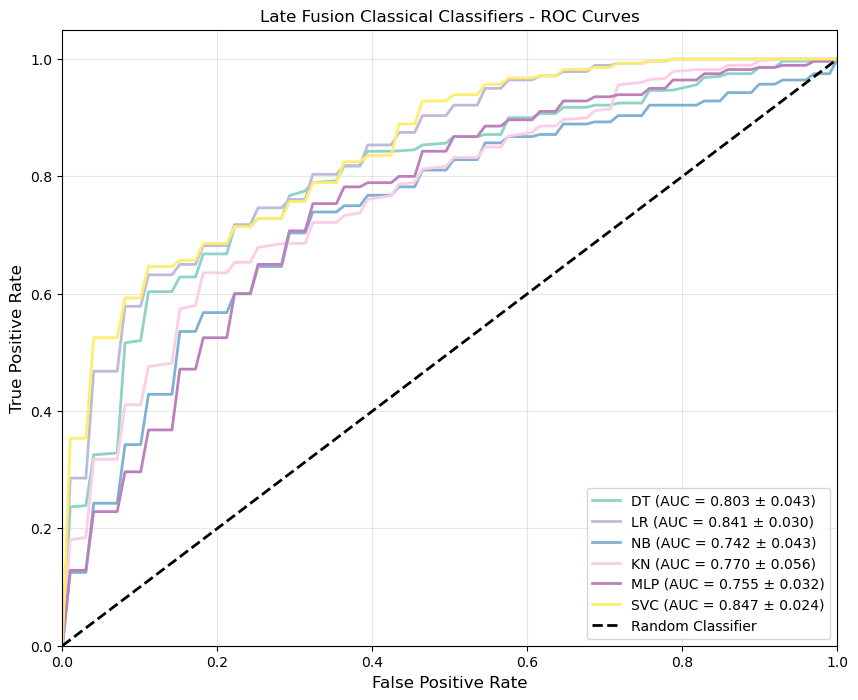

\nLate Fusion Classical - Friedman Test Statistic: 16.523668639053252, p-value: 0.005497643944763383
Late Fusion Classical - Critical Difference: 2.3844810756221153


<Figure size 1400x800 with 0 Axes>

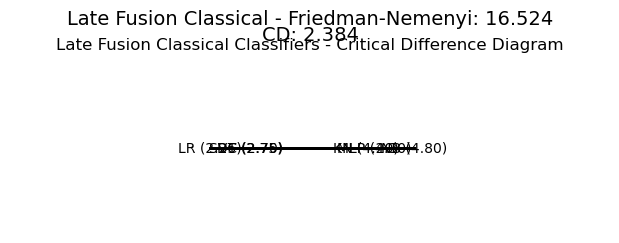

In [46]:
# Display Late Fusion Classical Results
print('\\nLate Fusion Classical - Average Metrics over 10 Random States:')
for clf_name, metrics in metric_sums_late_classical.items():
    avg_accuracy = metrics['accuracy'] / 10
    avg_precision = metrics['precision'] / 10
    avg_recall = metrics['recall'] / 10
    avg_f1 = metrics['f1'] / 10
    std_accuracy = np.std(accuracy_scores_late_classical[clf_name])
    std_precision = np.std(precision_scores_late_classical[clf_name])
    std_recall = np.std(recall_scores_late_classical[clf_name])
    std_f1 = np.std(f1_scores_late_classical[clf_name])
    avg_auc = np.mean(roc_aucs_late_classical[clf_name])
    print(f'{clf_name} - Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}, Precision: {avg_precision:.4f} ± {std_precision:.4f}, Recall: {avg_recall:.4f} ± {std_recall:.4f}, F1-Score: {avg_f1:.4f} ± {std_f1:.4f}, AUC: {avg_auc:.4f}')

# Plot ROC Curves for Late Fusion Classical
plot_combined_roc_curve(roc_curves_late_classical, classifiers_classical.keys())
plt.title('Late Fusion Classical Classifiers - ROC Curves')
plt.show()

# Friedman Test and CD Diagram for Late Fusion Classical
df_late_classical = pd.DataFrame(accuracy_scores_late_classical)
scores_late_classical = [df_late_classical[col].values for col in df_late_classical.columns]
stat_late_classical, p_late_classical = friedmanchisquare(*scores_late_classical)
print(f'\\nLate Fusion Classical - Friedman Test Statistic: {stat_late_classical}, p-value: {p_late_classical}')

ranks_late_classical = df_late_classical.rank(axis=1, method='average', ascending=False)
average_ranks_late_classical = ranks_late_classical.mean().values
n_datasets_late_classical = df_late_classical.shape[0]
cd_late_classical = compute_CD(average_ranks_late_classical, n_datasets_late_classical, alpha='0.05')
print(f'Late Fusion Classical - Critical Difference: {cd_late_classical}')

classifiers_ranked_late_classical = [f"{clf} ({rank:.2f})" for clf, rank in zip(df_late_classical.columns, average_ranks_late_classical)]
plt.figure(figsize=(14, 8))
graph_ranks(average_ranks_late_classical, classifiers_ranked_late_classical, cd=cd_late_classical, width=6, textspace=1)
plt.text(0.5, 1.19, f'Late Fusion Classical - Friedman-Nemenyi: {stat_late_classical:.3f}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
plt.text(0.5, 1.10, f'CD: {cd_late_classical:.3f}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
plt.title('Late Fusion Classical Classifiers - Critical Difference Diagram')
plt.tight_layout()
plt.show()

## Late Fusion - Static Classifiers

Training static ensemble classifiers on each dataset separately and combining predictions using a meta-classifier.

In [47]:
# Late Fusion Static Classifiers
base_rf_late = RandomForestClassifier(random_state=0)
base_ab_late = AdaBoostClassifier(random_state=0)
base_cb_late = CatBoostClassifier(random_state=0, verbose=0)

classifiers_static_late = {
    'RF': RandomForestClassifier(random_state=0),
    'XGB': XGBClassifier(random_state=0, eval_metric='logloss'),
    'GB': GradientBoostingClassifier(random_state=0),
    'AB': AdaBoostClassifier(random_state=0),
    'CB': CatBoostClassifier(random_state=0, verbose=0),
    'VOT': VotingClassifier(
        estimators=[('rf', base_rf_late), ('ab', base_ab_late), ('cb', base_cb_late)],
        voting='soft'
    ),
    'STACK': StackingClassifier(
        estimators=[('rf', base_rf_late), ('ab', base_ab_late), ('cb', base_cb_late)],
        final_estimator=LogisticRegression(random_state=0),
        cv=5
    )
}

# Initialize storage for late fusion static results
metric_sums_late_static = defaultdict(lambda: {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0})
conf_matrices_late_static = defaultdict(list)
roc_curves_late_static = defaultdict(list)
roc_aucs_late_static = defaultdict(list)
accuracy_scores_late_static = defaultdict(list)
precision_scores_late_static = defaultdict(list)
recall_scores_late_static = defaultdict(list)
f1_scores_late_static = defaultdict(list)

print("Starting Late Fusion Static Training...")

# Loop over 10 different random states
for random_state in range(10):
    print(f"\nProcessing Random State: {random_state}")
    
    # Preprocess all datasets with synchronized splits
    (X_tab_train, y_tab_train, X_tab_test, y_tab_test, scaler_tab,
     X_text_train, y_text_train, X_text_test, y_text_test, scaler_text,
     X_ts_train, y_ts_train, X_ts_test, y_ts_test, scaler_ts) = preprocess_datasets_synchronized(
        tabular_modeling, text_modeling, timeseries_modeling, random_state)
    
    print(f"Training set sizes - Tabular: {X_tab_train.shape[0]}, Text: {X_text_train.shape[0]}, TimeSeries: {X_ts_train.shape[0]}")
    print(f"Test set sizes - Tabular: {X_tab_test.shape[0]}, Text: {X_text_test.shape[0]}, TimeSeries: {X_ts_test.shape[0]}")
    
    # Feature selection (top 100 features for each dataset)
    # For tabular data
    log_reg_tab = LogisticRegression(C=0.09659168435718246, max_iter=100, solver='lbfgs', random_state=random_state)
    log_reg_tab.fit(X_tab_train, y_tab_train)
    importance_tab = np.abs(log_reg_tab.coef_[0])
    indices_tab = np.argsort(importance_tab)[::-1][:100]
    
    # For text data
    log_reg_text = LogisticRegression(C=0.09659168435718246, max_iter=100, solver='lbfgs', random_state=random_state)
    log_reg_text.fit(X_text_train, y_text_train)
    importance_text = np.abs(log_reg_text.coef_[0])
    indices_text = np.argsort(importance_text)[::-1][:100]
    
    # For time series data
    log_reg_ts = LogisticRegression(C=0.09659168435718246, max_iter=100, solver='lbfgs', random_state=random_state)
    log_reg_ts.fit(X_ts_train, y_ts_train)
    importance_ts = np.abs(log_reg_ts.coef_[0])
    indices_ts = np.argsort(importance_ts)[::-1][:100]
    
    # Select features
    X_tab_train_fs = X_tab_train[:, indices_tab]
    X_tab_test_fs = X_tab_test[:, indices_tab]
    X_text_train_fs = X_text_train[:, indices_text]
    X_text_test_fs = X_text_test[:, indices_text]
    X_ts_train_fs = X_ts_train[:, indices_ts]
    X_ts_test_fs = X_ts_test[:, indices_ts]
    
    # Train each classifier separately on each dataset and collect predictions
    for clf_name, clf in classifiers_static_late.items():
        print(f"Training {clf_name} for late fusion...")
        
        # Set random state for consistency
        if hasattr(clf, 'random_state'):
            clf.set_params(random_state=random_state)
        
        # Train on tabular data
        clf_tab = clone(clf)
        clf_tab.fit(X_tab_train_fs, y_tab_train)
        pred_tab_train = clf_tab.predict_proba(X_tab_train_fs)[:, 1] if hasattr(clf_tab, 'predict_proba') else clf_tab.decision_function(X_tab_train_fs)
        pred_tab_test = clf_tab.predict_proba(X_tab_test_fs)[:, 1] if hasattr(clf_tab, 'predict_proba') else clf_tab.decision_function(X_tab_test_fs)
        
        # Train on text data
        clf_text = clone(clf)
        clf_text.fit(X_text_train_fs, y_text_train)
        pred_text_train = clf_text.predict_proba(X_text_train_fs)[:, 1] if hasattr(clf_text, 'predict_proba') else clf_text.decision_function(X_text_train_fs)
        pred_text_test = clf_text.predict_proba(X_text_test_fs)[:, 1] if hasattr(clf_text, 'predict_proba') else clf_text.decision_function(X_text_test_fs)
        
        # Train on time series data
        clf_ts = clone(clf)
        clf_ts.fit(X_ts_train_fs, y_ts_train)
        pred_ts_train = clf_ts.predict_proba(X_ts_train_fs)[:, 1] if hasattr(clf_ts, 'predict_proba') else clf_ts.decision_function(X_ts_train_fs)
        pred_ts_test = clf_ts.predict_proba(X_ts_test_fs)[:, 1] if hasattr(clf_ts, 'predict_proba') else clf_ts.decision_function(X_ts_test_fs)
        
        # Create meta-features for this specific classifier (3 predictions: tab, text, ts)
        meta_X_train = np.column_stack([pred_tab_train, pred_text_train, pred_ts_train])
        meta_X_test = np.column_stack([pred_tab_test, pred_text_test, pred_ts_test])
        
        # Use the target from any dataset (they're all the same)
        meta_y_train = y_tab_train
        meta_y_test = y_tab_test
        
        print(f"  Meta-features shape for {clf_name} - Train: {meta_X_train.shape}, Test: {meta_X_test.shape}")
        
        # Train meta-classifier specific to this base classifier
        meta_clf = LogisticRegression(random_state=random_state, max_iter=1000)
        meta_clf.fit(meta_X_train, meta_y_train)
        
        # Make final predictions
        y_pred = meta_clf.predict(meta_X_test)
        y_score = meta_clf.predict_proba(meta_X_test)[:, 1]
        
        # Calculate metrics
        accuracy = accuracy_score(meta_y_test, y_pred)
        precision = precision_score(meta_y_test, y_pred, average='weighted')
        recall = recall_score(meta_y_test, y_pred, average='weighted')
        f1 = f1_score(meta_y_test, y_pred, average='weighted')
        conf_matrix = confusion_matrix(meta_y_test, y_pred)
        
        fpr, tpr, _ = roc_curve(meta_y_test, y_score)
        roc_auc = auc(fpr, tpr)
        
        print(f'  Late Fusion {clf_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, AUC: {roc_auc:.4f}')
        
        # Store results
        metric_sums_late_static[clf_name]['accuracy'] += accuracy
        metric_sums_late_static[clf_name]['precision'] += precision
        metric_sums_late_static[clf_name]['recall'] += recall
        metric_sums_late_static[clf_name]['f1'] += f1
        conf_matrices_late_static[clf_name].append(conf_matrix)
        roc_curves_late_static[clf_name].append((fpr, tpr))
        roc_aucs_late_static[clf_name].append(roc_auc)
        accuracy_scores_late_static[clf_name].append(accuracy)
        precision_scores_late_static[clf_name].append(precision)
        recall_scores_late_static[clf_name].append(recall)
        f1_scores_late_static[clf_name].append(f1)

print("\n" + "="*80)
print("LATE FUSION STATIC RESULTS")
print("="*80)

Starting Late Fusion Static Training...

Processing Random State: 0
Training set sizes - Tabular: 130, Text: 130, TimeSeries: 130
Test set sizes - Tabular: 56, Text: 56, TimeSeries: 56
Selected features - Tabular: 100, Text: 100, TimeSeries: 64
Training RF for late fusion...
Training set sizes - Tabular: 130, Text: 130, TimeSeries: 130
Test set sizes - Tabular: 56, Text: 56, TimeSeries: 56
Selected features - Tabular: 100, Text: 100, TimeSeries: 64
Training RF for late fusion...
  Meta-features shape for RF - Train: (130, 3), Test: (56, 3)
  Late Fusion RF - Accuracy: 0.7143, Precision: 0.7154, Recall: 0.7143, F1-Score: 0.7139, AUC: 0.7844
Training XGB for late fusion...
  Meta-features shape for RF - Train: (130, 3), Test: (56, 3)
  Late Fusion RF - Accuracy: 0.7143, Precision: 0.7154, Recall: 0.7143, F1-Score: 0.7139, AUC: 0.7844
Training XGB for late fusion...
  Meta-features shape for XGB - Train: (130, 3), Test: (56, 3)
  Late Fusion XGB - Accuracy: 0.7321, Precision: 0.7348, Reca

\nLate Fusion Static - Average Metrics over 10 Random States:
RF - Accuracy: 0.6589 ± 0.0520, Precision: 0.6618 ± 0.0535, Recall: 0.6589 ± 0.0520, F1-Score: 0.6574 ± 0.0523, AUC: 0.7276
XGB - Accuracy: 0.6696 ± 0.0531, Precision: 0.6753 ± 0.0548, Recall: 0.6696 ± 0.0531, F1-Score: 0.6670 ± 0.0535, AUC: 0.7429
GB - Accuracy: 0.7125 ± 0.0514, Precision: 0.7196 ± 0.0498, Recall: 0.7125 ± 0.0514, F1-Score: 0.7097 ± 0.0531, AUC: 0.7786
AB - Accuracy: 0.7036 ± 0.0409, Precision: 0.7059 ± 0.0421, Recall: 0.7036 ± 0.0409, F1-Score: 0.7028 ± 0.0410, AUC: 0.7448
CB - Accuracy: 0.7857 ± 0.0592, Precision: 0.7901 ± 0.0572, Recall: 0.7857 ± 0.0592, F1-Score: 0.7847 ± 0.0600, AUC: 0.8599
VOT - Accuracy: 0.7482 ± 0.0370, Precision: 0.7531 ± 0.0368, Recall: 0.7482 ± 0.0370, F1-Score: 0.7469 ± 0.0375, AUC: 0.8307
STACK - Accuracy: 0.7929 ± 0.0424, Precision: 0.8015 ± 0.0423, Recall: 0.7929 ± 0.0424, F1-Score: 0.7913 ± 0.0431, AUC: 0.8815


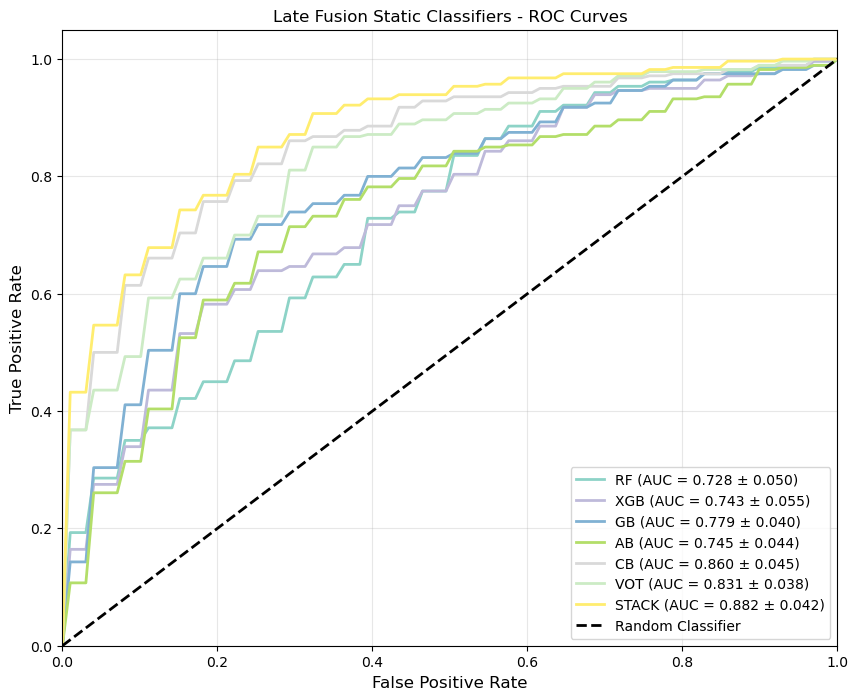

\nLate Fusion Static - Friedman Test Statistic: 46.20109689213895, p-value: 2.699791335096711e-08
Late Fusion Static - Critical Difference: 2.8490046683008434


<Figure size 1400x800 with 0 Axes>

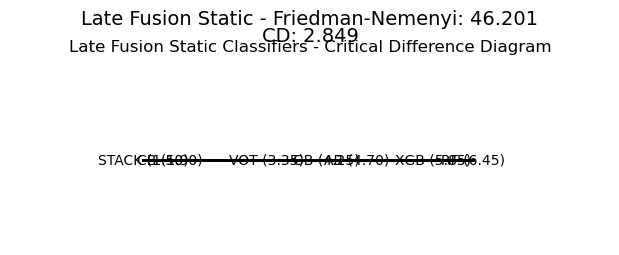

In [48]:
# Display Late Fusion Static Results
print('\\nLate Fusion Static - Average Metrics over 10 Random States:')
for clf_name, metrics in metric_sums_late_static.items():
    avg_accuracy = metrics['accuracy'] / 10
    avg_precision = metrics['precision'] / 10
    avg_recall = metrics['recall'] / 10
    avg_f1 = metrics['f1'] / 10
    std_accuracy = np.std(accuracy_scores_late_static[clf_name])
    std_precision = np.std(precision_scores_late_static[clf_name])
    std_recall = np.std(recall_scores_late_static[clf_name])
    std_f1 = np.std(f1_scores_late_static[clf_name])
    avg_auc = np.mean(roc_aucs_late_static[clf_name])
    print(f'{clf_name} - Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}, Precision: {avg_precision:.4f} ± {std_precision:.4f}, Recall: {avg_recall:.4f} ± {std_recall:.4f}, F1-Score: {avg_f1:.4f} ± {std_f1:.4f}, AUC: {avg_auc:.4f}')

# Plot ROC Curves for Late Fusion Static
plot_combined_roc_curve(roc_curves_late_static, classifiers_static_late.keys())
plt.title('Late Fusion Static Classifiers - ROC Curves')
plt.show()

# Friedman Test and CD Diagram for Late Fusion Static
df_late_static = pd.DataFrame(accuracy_scores_late_static)
scores_late_static = [df_late_static[col].values for col in df_late_static.columns]
stat_late_static, p_late_static = friedmanchisquare(*scores_late_static)
print(f'\\nLate Fusion Static - Friedman Test Statistic: {stat_late_static}, p-value: {p_late_static}')

ranks_late_static = df_late_static.rank(axis=1, method='average', ascending=False)
average_ranks_late_static = ranks_late_static.mean().values
n_datasets_late_static = df_late_static.shape[0]
cd_late_static = compute_CD(average_ranks_late_static, n_datasets_late_static, alpha='0.05')
print(f'Late Fusion Static - Critical Difference: {cd_late_static}')

classifiers_ranked_late_static = [f"{clf} ({rank:.2f})" for clf, rank in zip(df_late_static.columns, average_ranks_late_static)]
plt.figure(figsize=(14, 8))
graph_ranks(average_ranks_late_static, classifiers_ranked_late_static, cd=cd_late_static, width=6, textspace=1)
plt.text(0.5, 1.19, f'Late Fusion Static - Friedman-Nemenyi: {stat_late_static:.3f}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
plt.text(0.5, 1.10, f'CD: {cd_late_static:.3f}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
plt.title('Late Fusion Static Classifiers - Critical Difference Diagram')
plt.tight_layout()
plt.show()

In [71]:
# Hyperparameter Optimization for Late Fusion Static Classifiers
print("Starting Hyperparameter Optimization for Late Fusion Static Classifiers...")

# Clear previous results and initialize storage for optimized static results
metric_sums_late_static_opt = defaultdict(lambda: {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0})
conf_matrices_late_static_opt = defaultdict(list)
roc_curves_late_static_opt = defaultdict(list)
roc_aucs_late_static_opt = defaultdict(list)
accuracy_scores_late_static_opt = defaultdict(list)
precision_scores_late_static_opt = defaultdict(list)
recall_scores_late_static_opt = defaultdict(list)
f1_scores_late_static_opt = defaultdict(list)

def get_fresh_classifier_late(clf_name):
    """Return a fresh instance of the classifier for late fusion"""
    classifiers_fresh = {
        'RF': RandomForestClassifier(),
        'XGB': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'GB': GradientBoostingClassifier(),
        'AB': AdaBoostClassifier(),
        'CB': CatBoostClassifier(verbose=0),
        'VOT': VotingClassifier([
            ('rf', RandomForestClassifier()),
            ('ab', AdaBoostClassifier()),
            ('cb', CatBoostClassifier(verbose=0))
        ], voting='soft'),
        'STACK': StackingClassifier([
            ('rf', RandomForestClassifier()),
            ('ab', AdaBoostClassifier()),
            ('cb', CatBoostClassifier(verbose=0))
        ], final_estimator=LogisticRegression(), cv=3)
    }
    return classifiers_fresh[clf_name]

# Define search spaces for each classifier
search_spaces_late = {
    'RF': {
        'n_estimators': [100, 200, 300],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 7, 15],
        'bootstrap': [True, False]
    },
    'XGB': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'gamma': [0, 0.2, 0.4]
    },
    'GB': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 0.9, 1.0]
    },
    'AB': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.1, 0.5, 1.0],
        'algorithm': ['SAMME', 'SAMME.R']
    },
    'CB': {
        'iterations': [100, 200, 300],
        'depth': [5, 7, 9],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'VOT': {
        'rf__n_estimators': [100, 200],
        'ab__n_estimators': [100, 200],
        'cb__iterations': [100, 200]
    },
    'STACK': {
        'rf__n_estimators': [100, 200],
        'ab__n_estimators': [100, 200],
        'cb__iterations': [100, 200],
        'final_estimator__C': [0.1, 1.0, 10.0]
    }
}

# Number of features for each classifier
num_features_late = {
    'RF': 100,
    'XGB': 100,
    'GB': 100,
    'AB': 100,
    'CB': 100,
    'VOT': 100,
    'STACK': 100
}

def convert_params_to_int_late(params):
    """Convert float parameters to int where needed, handling NaN values"""
    int_params = ['n_estimators', 'max_depth', 'iterations', 'depth',
                  'rf__n_estimators', 'ab__n_estimators', 'cb__iterations']
    
    # Default values for parameters if NaN or missing
    default_values = {
        'n_estimators': 100,
        'max_depth': 7,
        'iterations': 100,
        'depth': 5,
        'rf__n_estimators': 100,
        'ab__n_estimators': 100,
        'cb__iterations': 100
    }
    
    for param in int_params:
        if param in params:
            if params[param] is None or pd.isna(params[param]):
                # Use default value if NaN or None
                params[param] = default_values.get(param, 100)
            else:
                try:
                    params[param] = int(params[param])
                except (ValueError, TypeError):
                    # Use default value if conversion fails
                    params[param] = default_values.get(param, 100)
    
    return params

def hyperparameter_optimization_late(clf, search_space, X, y, random_state):
    """Perform hyperparameter optimization for late fusion classifiers with better error handling"""
    try:
        combined_results = []
        for rs in range(3):
            cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=rs + random_state)
            opt = BayesSearchCV(clf, search_space, n_iter=15, cv=cv, 
                               random_state=rs + random_state, n_jobs=-1, verbose=0)
            opt.fit(X, y)
            if opt.best_params_:
                combined_results.append(opt.best_params_)
        
        if not combined_results:
            # Return default parameters if optimization failed
            default_params = {}
            for param_name, param_values in search_space.items():
                if isinstance(param_values, list):
                    default_params[param_name] = param_values[0]
            return default_params
        
        # Get the mode of parameters across different runs
        best_params = pd.DataFrame(combined_results).mode().iloc[0].to_dict()
        
        # Handle any remaining NaN values
        for param, value in best_params.items():
            if pd.isna(value):
                if param in search_space and isinstance(search_space[param], list):
                    best_params[param] = search_space[param][0]  # Use first value as default
                
        return best_params
        
    except Exception as e:
        print(f"  Error in hyperparameter optimization: {e}")
        # Return default parameters
        default_params = {}
        for param_name, param_values in search_space.items():
            if isinstance(param_values, list):
                default_params[param_name] = param_values[0]
        return default_params

# Loop over 10 different random states for optimization
for random_state in range(10):
    print(f"\nOptimizing Random State: {random_state}")
    
    try:
        # Preprocess all datasets with synchronized splits
        (X_tab_train, y_tab_train, X_tab_test, y_tab_test, scaler_tab,
         X_text_train, y_text_train, X_text_test, y_text_test, scaler_text,
         X_ts_train, y_ts_train, X_ts_test, y_ts_test, scaler_ts) = preprocess_datasets_synchronized(
            tabular_modeling, text_modeling, timeseries_modeling, random_state)
        
        print(f"Training set sizes - Tabular: {X_tab_train.shape[0]}, Text: {X_text_train.shape[0]}, TimeSeries: {X_ts_train.shape[0]}")
        
        # Feature selection using logistic regression for each dataset
        # For tabular data
        log_reg_tab = LogisticRegression(C=0.09659168435718246, max_iter=100, solver='lbfgs', random_state=random_state)
        log_reg_tab.fit(X_tab_train, y_tab_train)
        importance_tab = np.abs(log_reg_tab.coef_[0])
        indices_tab = np.argsort(importance_tab)[::-1][:300]
        
        # For text data
        log_reg_text = LogisticRegression(C=0.09659168435718246, max_iter=100, solver='lbfgs', random_state=random_state)
        log_reg_text.fit(X_text_train, y_text_train)
        importance_text = np.abs(log_reg_text.coef_[0])
        indices_text = np.argsort(importance_text)[::-1][:300]
        
        # For time series data
        log_reg_ts = LogisticRegression(C=0.09659168435718246, max_iter=100, solver='lbfgs', random_state=random_state)
        log_reg_ts.fit(X_ts_train, y_ts_train)
        importance_ts = np.abs(log_reg_ts.coef_[0])
        indices_ts = np.argsort(importance_ts)[::-1][:300]
        
        # Optimize each classifier
        for clf_name in ['RF', 'XGB', 'GB', 'AB', 'CB', 'VOT', 'STACK']:
            print(f"  Optimizing {clf_name}...")
            
            try:
                num_top_features = num_features_late[clf_name]
                
                # Select top features for each dataset
                selected_features_tab = indices_tab[:num_top_features]
                selected_features_text = indices_text[:num_top_features]
                selected_features_ts = indices_ts[:num_top_features]
                
                X_tab_train_fs = X_tab_train[:, selected_features_tab]
                X_tab_test_fs = X_tab_test[:, selected_features_tab]
                X_text_train_fs = X_text_train[:, selected_features_text]
                X_text_test_fs = X_text_test[:, selected_features_text]
                X_ts_train_fs = X_ts_train[:, selected_features_ts]
                X_ts_test_fs = X_ts_test[:, selected_features_ts]
                
                # Optimize hyperparameters for each dataset
                clf_fresh_tab = get_fresh_classifier_late(clf_name)
                clf_fresh_text = get_fresh_classifier_late(clf_name)
                clf_fresh_ts = get_fresh_classifier_late(clf_name)
                
                best_params_tab = hyperparameter_optimization_late(
                    clf_fresh_tab, search_spaces_late[clf_name], X_tab_train_fs, y_tab_train, random_state)
                best_params_text = hyperparameter_optimization_late(
                    clf_fresh_text, search_spaces_late[clf_name], X_text_train_fs, y_text_train, random_state)
                best_params_ts = hyperparameter_optimization_late(
                    clf_fresh_ts, search_spaces_late[clf_name], X_ts_train_fs, y_ts_train, random_state)
                
                # Convert float parameters to int with NaN handling
                best_params_tab = convert_params_to_int_late(best_params_tab)
                best_params_text = convert_params_to_int_late(best_params_text)
                best_params_ts = convert_params_to_int_late(best_params_ts)
                
                print(f"    Best params - Tabular: {best_params_tab}")
                print(f"    Best params - Text: {best_params_text}")
                print(f"    Best params - TimeSeries: {best_params_ts}")
                
                # Create optimized classifiers for each dataset
                clf_opt_tab = get_fresh_classifier_late(clf_name)
                clf_opt_text = get_fresh_classifier_late(clf_name)
                clf_opt_ts = get_fresh_classifier_late(clf_name)
                
                # Set random state for reproducibility
                if hasattr(clf_opt_tab, 'random_state'):
                    clf_opt_tab.set_params(random_state=random_state)
                    clf_opt_text.set_params(random_state=random_state)
                    clf_opt_ts.set_params(random_state=random_state)
                
                # Apply optimized parameters
                clf_opt_tab.set_params(**best_params_tab)
                clf_opt_text.set_params(**best_params_text)
                clf_opt_ts.set_params(**best_params_ts)
                
                # Train optimized classifiers
                clf_opt_tab.fit(X_tab_train_fs, y_tab_train)
                clf_opt_text.fit(X_text_train_fs, y_text_train)
                clf_opt_ts.fit(X_ts_train_fs, y_ts_train)
                
                # Make predictions
                pred_tab_train = clf_opt_tab.predict_proba(X_tab_train_fs)[:, 1] if hasattr(clf_opt_tab, 'predict_proba') else clf_opt_tab.decision_function(X_tab_train_fs)
                pred_tab_test = clf_opt_tab.predict_proba(X_tab_test_fs)[:, 1] if hasattr(clf_opt_tab, 'predict_proba') else clf_opt_tab.decision_function(X_tab_test_fs)
                
                pred_text_train = clf_opt_text.predict_proba(X_text_train_fs)[:, 1] if hasattr(clf_opt_text, 'predict_proba') else clf_opt_text.decision_function(X_text_train_fs)
                pred_text_test = clf_opt_text.predict_proba(X_text_test_fs)[:, 1] if hasattr(clf_opt_text, 'predict_proba') else clf_opt_text.decision_function(X_text_test_fs)
                
                pred_ts_train = clf_opt_ts.predict_proba(X_ts_train_fs)[:, 1] if hasattr(clf_opt_ts, 'predict_proba') else clf_opt_ts.decision_function(X_ts_train_fs)
                pred_ts_test = clf_opt_ts.predict_proba(X_ts_test_fs)[:, 1] if hasattr(clf_opt_ts, 'predict_proba') else clf_opt_ts.decision_function(X_ts_test_fs)
                
                # Create meta-features for this specific classifier (3 predictions: tab, text, ts)
                meta_X_train = np.column_stack([pred_tab_train, pred_text_train, pred_ts_train])
                meta_X_test = np.column_stack([pred_tab_test, pred_text_test, pred_ts_test])
                
                # Use the target from any dataset (they're all the same)
                meta_y_train = y_tab_train
                meta_y_test = y_tab_test
                
                # Train optimized meta-classifier
                meta_clf = LogisticRegression(random_state=random_state, max_iter=1000, C=1.0)
                meta_clf.fit(meta_X_train, meta_y_train)
                
                # Make final predictions
                y_pred = meta_clf.predict(meta_X_test)
                y_score = meta_clf.predict_proba(meta_X_test)[:, 1]
                
                # Calculate metrics
                accuracy = accuracy_score(meta_y_test, y_pred)
                precision = precision_score(meta_y_test, y_pred, average='weighted')
                recall = recall_score(meta_y_test, y_pred, average='weighted')
                f1 = f1_score(meta_y_test, y_pred, average='weighted')
                conf_matrix = confusion_matrix(meta_y_test, y_pred)
                
                fpr, tpr, _ = roc_curve(meta_y_test, y_score)
                roc_auc = auc(fpr, tpr)
                
                print(f'    Optimized Late Fusion {clf_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, AUC: {roc_auc:.4f}')
                
                # Store results
                metric_sums_late_static_opt[clf_name]['accuracy'] += accuracy
                metric_sums_late_static_opt[clf_name]['precision'] += precision
                metric_sums_late_static_opt[clf_name]['recall'] += recall
                metric_sums_late_static_opt[clf_name]['f1'] += f1
                conf_matrices_late_static_opt[clf_name].append(conf_matrix)
                roc_curves_late_static_opt[clf_name].append((fpr, tpr))
                roc_aucs_late_static_opt[clf_name].append(roc_auc)
                accuracy_scores_late_static_opt[clf_name].append(accuracy)
                precision_scores_late_static_opt[clf_name].append(precision)
                recall_scores_late_static_opt[clf_name].append(recall)
                f1_scores_late_static_opt[clf_name].append(f1)
                
            except Exception as e:
                print(f"    Error optimizing {clf_name}: {e}")
                # Store default results for failed optimization
                default_accuracy = 0.5
                metric_sums_late_static_opt[clf_name]['accuracy'] += default_accuracy
                metric_sums_late_static_opt[clf_name]['precision'] += default_accuracy
                metric_sums_late_static_opt[clf_name]['recall'] += default_accuracy
                metric_sums_late_static_opt[clf_name]['f1'] += default_accuracy
                accuracy_scores_late_static_opt[clf_name].append(default_accuracy)
                precision_scores_late_static_opt[clf_name].append(default_accuracy)
                recall_scores_late_static_opt[clf_name].append(default_accuracy)
                f1_scores_late_static_opt[clf_name].append(default_accuracy)
                roc_aucs_late_static_opt[clf_name].append(default_accuracy)
                
    except Exception as e:
        print(f"Error processing random state {random_state}: {e}")
        continue

print("\n" + "="*80)
print("LATE FUSION STATIC HYPERPARAMETER OPTIMIZATION COMPLETE")
print("="*80)

# Display optimized results
print('\nOptimized Late Fusion Static - Average Metrics over Random States:')
for clf_name, metrics in metric_sums_late_static_opt.items():
    num_runs = len(accuracy_scores_late_static_opt[clf_name])
    if num_runs > 0:
        avg_accuracy = metrics['accuracy'] / num_runs
        avg_precision = metrics['precision'] / num_runs
        avg_recall = metrics['recall'] / num_runs
        avg_f1 = metrics['f1'] / num_runs
        std_accuracy = np.std(accuracy_scores_late_static_opt[clf_name])
        std_precision = np.std(precision_scores_late_static_opt[clf_name])
        std_recall = np.std(recall_scores_late_static_opt[clf_name])
        std_f1 = np.std(f1_scores_late_static_opt[clf_name])
        avg_auc = np.mean(roc_aucs_late_static_opt[clf_name])
        print(f'{clf_name} - Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}, Precision: {avg_precision:.4f} ± {std_precision:.4f}, Recall: {avg_recall:.4f} ± {std_recall:.4f}, F1-Score: {avg_f1:.4f} ± {std_f1:.4f}, AUC: {avg_auc:.4f}')

# Plot ROC Curves for Optimized Late Fusion Static
valid_roc_curves_opt = {k: v for k, v in roc_curves_late_static_opt.items() if len(v) > 0}
if valid_roc_curves_opt:
    plot_combined_roc_curve(valid_roc_curves_opt, valid_roc_curves_opt.keys())
    plt.title('Optimized Late Fusion Static Classifiers - ROC Curves')
    plt.show()

# Comparison with non-optimized results
print('\n' + "="*60)
print("COMPARISON: OPTIMIZED vs NON-OPTIMIZED")
print("="*60)
for clf_name in metric_sums_late_static_opt.keys():
    if clf_name in metric_sums_late_static and len(roc_aucs_late_static_opt[clf_name]) > 0:
        orig_auc = np.mean(roc_aucs_late_static[clf_name])
        opt_auc = np.mean(roc_aucs_late_static_opt[clf_name])
        improvement = ((opt_auc - orig_auc) / orig_auc) * 100
        print(f'{clf_name}: Original AUC: {orig_auc:.4f} → Optimized AUC: {opt_auc:.4f} (Improvement: {improvement:+.2f}%)')

Starting Hyperparameter Optimization for Late Fusion Static Classifiers...

Optimizing Random State: 0
Training set sizes - Tabular: 130, Text: 130, TimeSeries: 130
  Optimizing RF...
    Best params - Tabular: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 200}
    Best params - Text: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 7, 'n_estimators': 200}
    Best params - TimeSeries: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 7, 'n_estimators': 100}
    Optimized Late Fusion RF - Accuracy: 0.7857, Precision: 0.7917, Recall: 0.7857, F1-Score: 0.7846, AUC: 0.8457
  Optimizing XGB...
    Best params - Tabular: {'gamma': 0.4, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
    Best params - Text: {'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
    Best params - TimeSeries: {'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
    Optimized Late Fusion XGB - Accuracy: 0.6964, Precis

KeyboardInterrupt: 

In [ ]:
# Enhanced Late Fusion DES Classifiers with Bayesian Optimization
from sklearn.base import clone
from copy import deepcopy

# Initialize storage for late fusion DES results
metric_sums_late_des = {
    'KNORAE': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'KNORAU': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'KNOP': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'DESMI': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'METADES': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'DESKNN': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'DESP': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-KNORA-U': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-KNORA-E': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-METADES': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-DESKNN': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-DESP': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-KNOP': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
}

conf_matrices_late_des = {key: [] for key in metric_sums_late_des.keys()}
roc_curves_late_des = defaultdict(list)
roc_aucs_late_des = defaultdict(list)
accuracy_scores_late_des = defaultdict(list)
precision_scores_late_des = defaultdict(list)
recall_scores_late_des = defaultdict(list)
f1_scores_late_des = defaultdict(list)

def get_optimized_static_params_for_des():
    """
    Use the specific optimized parameters from hyperparameter optimization results
    These parameters showed good performance for late fusion static classifiers
    """
    best_params = {
        'RF': {
            'tabular': {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 200},
            'text': {'bootstrap': False, 'criterion': 'gini', 'max_depth': 7, 'n_estimators': 200},
            'timeseries': {'bootstrap': True, 'criterion': 'gini', 'max_depth': 7, 'n_estimators': 100}
        },
        'XGB': {
            'tabular': {'gamma': 0.4, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100},
            'text': {'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300},
            'timeseries': {'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
        },
        'GB': {
            'tabular': {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7},
            'text': {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7},
            'timeseries': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.7}
        },
        'AB': {
            'tabular': {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 100},
            'text': {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 300},
            'timeseries': {'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 100}
        },
        'CB': {
            'tabular': {'depth': 7, 'iterations': 200, 'learning_rate': 0.01},
            'text': {'depth': 9, 'iterations': 200, 'learning_rate': 0.01},
            'timeseries': {'depth': 5, 'iterations': 100, 'learning_rate': 0.2}
        }
    }
    
    print("  Using optimized parameters from hyperparameter optimization:")
    for clf_name in best_params:
        print(f"    {clf_name}: Using dataset-specific optimized parameters")
    
    return best_params

# Function to create and fit base classifiers for DES (enhanced with optimized parameters)
def create_and_fit_base_classifiers_late(X_train, y_train, random_state, dataset_type='tabular'):
    """Create and fit enhanced base classifiers for DES using optimized parameters"""
    
    print(f"  Creating base classifiers with optimized parameters for {dataset_type} data...")
    best_static_params = get_optimized_static_params_for_des()
    
    # Initialize base classifiers with optimized parameters
    base_classifiers = []
    
    # RandomForest with optimized parameters
    rf_params = best_static_params['RF'][dataset_type].copy()
    rf_params['random_state'] = random_state
    base_classifiers.append(RandomForestClassifier(**rf_params))
    
    # CatBoost with optimized parameters
    cb_params = best_static_params['CB'][dataset_type].copy()
    cb_params.update({'random_state': random_state, 'verbose': 0})
    base_classifiers.append(CatBoostClassifier(**cb_params))
    
    # AdaBoost with optimized parameters
    ab_params = best_static_params['AB'][dataset_type].copy()
    ab_params['random_state'] = random_state
    base_classifiers.append(AdaBoostClassifier(**ab_params))
    
    # XGBoost with optimized parameters
    xgb_params = best_static_params['XGB'][dataset_type].copy()
    xgb_params.update({
        'random_state': random_state,
        'use_label_encoder': False,
        'eval_metric': 'mlogloss'
    })
    base_classifiers.append(XGBClassifier(**xgb_params))
    
    # GradientBoosting with optimized parameters
    gb_params = best_static_params['GB'][dataset_type].copy()
    gb_params['random_state'] = random_state
    base_classifiers.append(GradientBoostingClassifier(**gb_params))
    
    # Create optimized Voting and Stacking classifiers using the best individual classifiers
    rf_for_ensemble = clone(base_classifiers[0])  # Use the optimized RF
    ab_for_ensemble = clone(base_classifiers[2])  # Use the optimized AB
    cb_for_ensemble = clone(base_classifiers[1])  # Use the optimized CB
    
    voting_clf = VotingClassifier([
        ('rf', rf_for_ensemble),
        ('ada', ab_for_ensemble),
        ('cat', cb_for_ensemble)
    ], voting='soft')
    
    stacking_clf = StackingClassifier([
        ('rf', clone(base_classifiers[0])),
        ('ada', clone(base_classifiers[2])),
        ('cat', clone(base_classifiers[1]))
    ], final_estimator=LogisticRegression(random_state=random_state), cv=3)
    
    base_classifiers.extend([voting_clf, stacking_clf])
    
    # Fit all base classifiers
    fitted_classifiers = []
    for i, clf in enumerate(base_classifiers):
        try:
            clf_copy = clone(clf)
            clf_copy.fit(X_train, y_train)
            fitted_classifiers.append(clf_copy)
        except Exception as e:
            print(f"    Warning: Failed to fit base classifier {i}: {e}")
            continue
    
    print(f"    Successfully created {len(fitted_classifiers)} base classifiers")
    return fitted_classifiers

# Enhanced search space definitions for each DES algorithm
def get_search_space_late(des_name):
    """Define search space for each DES algorithm with correct parameters"""
    if des_name in ['KNORAE', 'FIRE-KNORA-E']:
        return [
            Integer(3, 15, name='k'),
            Categorical([True, False], name='with_IH')
        ]
    elif des_name in ['KNORAU', 'FIRE-KNORA-U']:
        return [
            Integer(3, 15, name='k'),
            Categorical([True, False], name='with_IH')
        ]
    elif des_name in ['METADES', 'FIRE-METADES']:
        return [
            Integer(3, 15, name='k'),
            Real(0.5, 0.9, name='Hc')
        ]
    elif des_name in ['DESKNN', 'FIRE-DESKNN']:
        # DESKNN doesn't use theta parameter - only k
        return [
            Integer(3, 15, name='k')
        ]
    elif des_name in ['DESP', 'FIRE-DESP']:
        # DESP also doesn't use theta parameter - only k
        return [
            Integer(3, 15, name='k')
        ]
    elif des_name in ['KNOP', 'FIRE-KNOP']:
        return [
            Integer(3, 15, name='k')
        ]
    elif des_name == 'DESMI':
        # DESMI has different parameters - only k parameter
        return [
            Integer(3, 15, name='k')
        ]
    else:
        return [Integer(3, 15, name='k')]

def create_des_model_late_optimized(des_name, model_pool, random_state, **params):
    """Create a DES model with optimized parameters using DFP for FIRE variants"""
    # Convert k to integer if necessary
    if 'k' in params:
        params['k'] = int(params['k'])
    
    if des_name == 'KNORAE':
        return KNORAE(
            pool_classifiers=model_pool, 
            DFP=False, 
            random_state=random_state, 
            k=params.get('k', 7),
            with_IH=params.get('with_IH', True)
        )
    elif des_name == 'KNORAU':
        return KNORAU(
            pool_classifiers=model_pool, 
            DFP=False, 
            random_state=random_state, 
            k=params.get('k', 7),
            with_IH=params.get('with_IH', True)
        )
    elif des_name == 'KNOP':
        return KNOP(
            pool_classifiers=model_pool, 
            DFP=False, 
            random_state=random_state, 
            k=params.get('k', 7)
        )
    elif des_name == 'DESMI':
        # DESMI doesn't use theta parameter - only k
        return DESMI(
            pool_classifiers=model_pool, 
            DFP=False, 
            random_state=random_state, 
            k=params.get('k', 7)
        )
    elif des_name == 'METADES':
        return METADES(
            pool_classifiers=model_pool, 
            DFP=False, 
            random_state=random_state, 
            k=params.get('k', 7),
            Hc=params.get('Hc', 0.5)
        )
    elif des_name == 'DESKNN':
        # DESKNN doesn't use theta parameter - only k
        return DESKNN(
            pool_classifiers=model_pool, 
            DFP=False, 
            random_state=random_state, 
            k=params.get('k', 7)
        )
    elif des_name == 'DESP':
        # DESP doesn't use theta parameter - only k
        return DESP(
            pool_classifiers=model_pool, 
            DFP=False, 
            random_state=random_state, 
            k=params.get('k', 7)
        )
    elif des_name == 'FIRE-KNORA-U':
        return KNORAU(
            pool_classifiers=model_pool, 
            DFP=True, 
            random_state=random_state, 
            k=params.get('k', 7),
            with_IH=params.get('with_IH', True)
        )
    elif des_name == 'FIRE-KNORA-E':
        return KNORAE(
            pool_classifiers=model_pool, 
            DFP=True, 
            random_state=random_state, 
            k=params.get('k', 7),
            with_IH=params.get('with_IH', True)
        )
    elif des_name == 'FIRE-METADES':
        return METADES(
            pool_classifiers=model_pool, 
            DFP=True, 
            random_state=random_state, 
            k=params.get('k', 7),
            Hc=params.get('Hc', 0.5)
        )
    elif des_name == 'FIRE-DESKNN':
        # FIRE-DESKNN also doesn't use theta parameter - only k
        return DESKNN(
            pool_classifiers=model_pool, 
            DFP=True, 
            random_state=random_state, 
            k=params.get('k', 7)
        )
    elif des_name == 'FIRE-DESP':
        # FIRE-DESP also doesn't use theta parameter - only k
        return DESP(
            pool_classifiers=model_pool, 
            DFP=True, 
            random_state=random_state, 
            k=params.get('k', 7)
        )
    elif des_name == 'FIRE-KNOP':
        return KNOP(
            pool_classifiers=model_pool, 
            DFP=True, 
            random_state=random_state, 
            k=params.get('k', 7)
        )
    else:
        raise ValueError(f"Unknown DES method: {des_name}")

def optimize_des_model_late(des_name, model_pool, X_train_val, y_train_val, X_val, y_val, random_state, n_calls=15):
    """Optimize DES model hyperparameters using Bayesian optimization"""
    search_space = get_search_space_late(des_name)
    
    @use_named_args(search_space)
    def objective(**params):
        try:
            # Create the DES model with current parameters
            des_model = create_des_model_late_optimized(des_name, model_pool, random_state, **params)
            
            # Train and evaluate the model
            des_model.fit(X_train_val, y_train_val)
            y_pred = des_model.predict(X_val)
            
            # Calculate accuracy (minimize 1 - accuracy)
            accuracy = accuracy_score(y_val, y_pred)
            return 1 - accuracy
            
        except Exception as e:
            print(f"Error during optimization for {des_name}: {e}")
            return 1.0  # Return high value on error
    
    # Bayesian optimization
    result = gp_minimize(objective, search_space, n_calls=n_calls, random_state=random_state)
    
    # Extract best parameters
    best_params = {}
    for i, param_name in enumerate([space.name for space in search_space]):
        best_params[param_name] = result.x[i]
    
    return best_params, 1 - result.fun  # Return best accuracy

print("Starting Enhanced Late Fusion DES Training with Optimized Base Classifiers...")

# Loop over 10 different random states
for random_state in range(10):
    print(f"\nProcessing Random State: {random_state}")
    
    # Preprocess all datasets with synchronized splits
    (X_tab_train, y_tab_train, X_tab_test, y_tab_test, scaler_tab,
     X_text_train, y_text_train, X_text_test, y_text_test, scaler_text,
     X_ts_train, y_ts_train, X_ts_test, y_ts_test, scaler_ts) = preprocess_datasets_synchronized(
        tabular_modeling, text_modeling, timeseries_modeling, random_state)
    
    print(f"Training set sizes - Tabular: {X_tab_train.shape[0]}, Text: {X_text_train.shape[0]}, TimeSeries: {X_ts_train.shape[0]}")
    print(f"Test set sizes - Tabular: {X_tab_test.shape[0]}, Text: {X_text_test.shape[0]}, TimeSeries: {X_ts_test.shape[0]}")
    
    # Enhanced feature selection using XGBoost (top 50 features for each dataset)
    # For tabular data
    xgb_fs_tab = XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, 
                               use_label_encoder=False, eval_metric='mlogloss', random_state=random_state)
    xgb_fs_tab.fit(X_tab_train, y_tab_train)
    feature_importances_tab = xgb_fs_tab.feature_importances_
    indices_tab = np.argsort(feature_importances_tab)[::-1][:50]
    
    # For text data
    xgb_fs_text = XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1,
                                use_label_encoder=False, eval_metric='mlogloss', random_state=random_state)
    xgb_fs_text.fit(X_text_train, y_text_train)
    feature_importances_text = xgb_fs_text.feature_importances_
    indices_text = np.argsort(feature_importances_text)[::-1][:50]
    
    # For time series data
    xgb_fs_ts = XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1,
                              use_label_encoder=False, eval_metric='mlogloss', random_state=random_state)
    xgb_fs_ts.fit(X_ts_train, y_ts_train)
    feature_importances_ts = xgb_fs_ts.feature_importances_
    indices_ts = np.argsort(feature_importances_ts)[::-1][:50]
    
    # Select features
    X_tab_train_fs = X_tab_train[:, indices_tab]
    X_tab_test_fs = X_tab_test[:, indices_tab]
    X_text_train_fs = X_text_train[:, indices_text]
    X_text_test_fs = X_text_test[:, indices_text]
    X_ts_train_fs = X_ts_train[:, indices_ts]
    X_ts_test_fs = X_ts_test[:, indices_ts]
    
    print(f"Selected features - Tabular: {X_tab_train_fs.shape[1]}, Text: {X_text_train_fs.shape[1]}, TimeSeries: {X_ts_train_fs.shape[1]}")
    
    # Create validation splits for optimization
    X_tab_train_val, X_tab_val, y_tab_train_val, y_tab_val = train_test_split(
        X_tab_train_fs, y_tab_train, test_size=0.2, stratify=y_tab_train, random_state=random_state
    )
    X_text_train_val, X_text_val, y_text_train_val, y_text_val = train_test_split(
        X_text_train_fs, y_text_train, test_size=0.2, stratify=y_text_train, random_state=random_state
    )
    X_ts_train_val, X_ts_val, y_ts_train_val, y_ts_val = train_test_split(
        X_ts_train_fs, y_ts_train, test_size=0.2, stratify=y_ts_train, random_state=random_state
    )
    
    # Create and fit optimized base classifiers for each dataset with dataset-specific parameters
    base_classifiers_tab = create_and_fit_base_classifiers_late(X_tab_train_fs, y_tab_train, random_state, 'tabular')
    base_classifiers_text = create_and_fit_base_classifiers_late(X_text_train_fs, y_text_train, random_state, 'text')
    base_classifiers_ts = create_and_fit_base_classifiers_late(X_ts_train_fs, y_ts_train, random_state, 'timeseries')
    
    # Define DES methods (prioritize top performers)
    des_methods = ['KNORAE', 'KNORAU', 'KNOP', 'DESMI', 'METADES', 'DESKNN', 'DESP', 
                   'FIRE-KNORA-U', 'FIRE-KNORA-E', 'FIRE-METADES', 'FIRE-DESKNN', 'FIRE-DESP', 'FIRE-KNOP']
    
    # Train each DES classifier with Bayesian optimization
    for des_name in des_methods:
        print(f"Optimizing {des_name} for late fusion...")
        
        try:
            # Optimize hyperparameters for tabular data
            best_params_tab, best_score_tab = optimize_des_model_late(
                des_name, base_classifiers_tab, X_tab_train_val, y_tab_train_val, X_tab_val, y_tab_val, random_state
            )
            
            # Optimize hyperparameters for text data
            best_params_text, best_score_text = optimize_des_model_late(
                des_name, base_classifiers_text, X_text_train_val, y_text_train_val, X_text_val, y_text_val, random_state
            )
            
            # Optimize hyperparameters for time series data
            best_params_ts, best_score_ts = optimize_des_model_late(
                des_name, base_classifiers_ts, X_ts_train_val, y_ts_train_val, X_ts_val, y_ts_val, random_state
            )
            
            print(f"  Best params - Tabular: {best_params_tab} (score: {best_score_tab:.4f})")
            print(f"  Best params - Text: {best_params_text} (score: {best_score_text:.4f})")
            print(f"  Best params - TimeSeries: {best_params_ts} (score: {best_score_ts:.4f})")
            
            # Create final optimized models
            clf_tab = create_des_model_late_optimized(des_name, base_classifiers_tab, random_state, **best_params_tab)
            clf_text = create_des_model_late_optimized(des_name, base_classifiers_text, random_state, **best_params_text)
            clf_ts = create_des_model_late_optimized(des_name, base_classifiers_ts, random_state, **best_params_ts)
            
            # Fit DES classifiers on full training data
            clf_tab.fit(X_tab_train_fs, y_tab_train)
            clf_text.fit(X_text_train_fs, y_text_train)
            clf_ts.fit(X_ts_train_fs, y_ts_train)
            
            # Make predictions
            pred_tab_train = clf_tab.predict_proba(X_tab_train_fs)[:, 1]
            pred_tab_test = clf_tab.predict_proba(X_tab_test_fs)[:, 1]
            
            pred_text_train = clf_text.predict_proba(X_text_train_fs)[:, 1]
            pred_text_test = clf_text.predict_proba(X_text_test_fs)[:, 1]
            
            pred_ts_train = clf_ts.predict_proba(X_ts_train_fs)[:, 1]
            pred_ts_test = clf_ts.predict_proba(X_ts_test_fs)[:, 1]
            
            # Create meta-features
            meta_X_train = np.column_stack([pred_tab_train, pred_text_train, pred_ts_train])
            meta_X_test = np.column_stack([pred_tab_test, pred_text_test, pred_ts_test])
            
            meta_y_train = y_tab_train
            meta_y_test = y_tab_test
            
            print(f"  Meta-features shape for {des_name} - Train: {meta_X_train.shape}, Test: {meta_X_test.shape}")
            
            # Train optimized meta-classifier
            meta_clf = LogisticRegression(random_state=random_state, max_iter=1000, C=1.0)
            meta_clf.fit(meta_X_train, meta_y_train)
            
            # Make final predictions
            y_pred = meta_clf.predict(meta_X_test)
            y_score = meta_clf.predict_proba(meta_X_test)[:, 1]
            
            # Calculate metrics
            accuracy = accuracy_score(meta_y_test, y_pred)
            precision = precision_score(meta_y_test, y_pred, average='weighted')
            recall = recall_score(meta_y_test, y_pred, average='weighted')
            f1 = f1_score(meta_y_test, y_pred, average='weighted')
            conf_matrix = confusion_matrix(meta_y_test, y_pred)
            
            fpr, tpr, _ = roc_curve(meta_y_test, y_score)
            roc_auc = auc(fpr, tpr)
            
            print(f'  Late Fusion {des_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, AUC: {roc_auc:.4f}')
            
            # Store results
            metric_sums_late_des[des_name]['accuracy'] += accuracy
            metric_sums_late_des[des_name]['precision'] += precision
            metric_sums_late_des[des_name]['recall'] += recall
            metric_sums_late_des[des_name]['f1'] += f1
            conf_matrices_late_des[des_name].append(conf_matrix)
            roc_curves_late_des[des_name].append((fpr, tpr))
            roc_aucs_late_des[des_name].append(roc_auc)
            accuracy_scores_late_des[des_name].append(accuracy)
            precision_scores_late_des[des_name].append(precision)
            recall_scores_late_des[des_name].append(recall)
            f1_scores_late_des[des_name].append(f1)
            
        except Exception as e:
            print(f"  Error training {des_name}: {str(e)}")
            # Add default values for failed training
            metric_sums_late_des[des_name]['accuracy'] += 0.5
            metric_sums_late_des[des_name]['precision'] += 0.5
            metric_sums_late_des[des_name]['recall'] += 0.5
            metric_sums_late_des[des_name]['f1'] += 0.5
            accuracy_scores_late_des[des_name].append(0.5)
            precision_scores_late_des[des_name].append(0.5)
            recall_scores_late_des[des_name].append(0.5)
            f1_scores_late_des[des_name].append(0.5)
            roc_aucs_late_des[des_name].append(0.5)

print("\n" + "="*80)
print("ENHANCED LATE FUSION DES RESULTS WITH OPTIMIZED BASE CLASSIFIERS")
print("="*80)

Starting Enhanced Late Fusion DES Training with Optimized Base Classifiers...

Processing Random State: 0
Training set sizes - Tabular: 130, Text: 130, TimeSeries: 130
Test set sizes - Tabular: 56, Text: 56, TimeSeries: 56
Training set sizes - Tabular: 130, Text: 130, TimeSeries: 130
Test set sizes - Tabular: 56, Text: 56, TimeSeries: 56
Selected features - Tabular: 50, Text: 50, TimeSeries: 50
  Creating base classifiers with optimized parameters for tabular data...
  Using optimized parameters from hyperparameter optimization:
    RF: Using dataset-specific optimized parameters
    XGB: Using dataset-specific optimized parameters
    GB: Using dataset-specific optimized parameters
    AB: Using dataset-specific optimized parameters
    CB: Using dataset-specific optimized parameters
Selected features - Tabular: 50, Text: 50, TimeSeries: 50
  Creating base classifiers with optimized parameters for tabular data...
  Using optimized parameters from hyperparameter optimization:
    RF: U


Late Fusion DES - Average Metrics over 10 Random States:
KNORAE - Accuracy: 0.7554 ± 0.0383, Precision: 0.7585 ± 0.0381, Recall: 0.7554 ± 0.0383, F1-Score: 0.7546 ± 0.0386, AUC: 0.8117
KNORAU - Accuracy: 0.7161 ± 0.0589, Precision: 0.7183 ± 0.0587, Recall: 0.7161 ± 0.0589, F1-Score: 0.7153 ± 0.0593, AUC: 0.7726
KNOP - No results (failed to train)
DESMI - No results (failed to train)
METADES - Accuracy: 0.7589 ± 0.0377, Precision: 0.7622 ± 0.0384, Recall: 0.7589 ± 0.0377, F1-Score: 0.7582 ± 0.0377, AUC: 0.8187
DESKNN - No results (failed to train)
DESP - No results (failed to train)
FIRE-KNORA-U - Accuracy: 0.7179 ± 0.0569, Precision: 0.7199 ± 0.0566, Recall: 0.7179 ± 0.0569, F1-Score: 0.7171 ± 0.0573, AUC: 0.7732
FIRE-KNORA-E - Accuracy: 0.7554 ± 0.0383, Precision: 0.7585 ± 0.0381, Recall: 0.7554 ± 0.0383, F1-Score: 0.7546 ± 0.0386, AUC: 0.8117
FIRE-METADES - No results (failed to train)
FIRE-DESKNN - No results (failed to train)
FIRE-DESP - No results (failed to train)
FIRE-KNOP - No

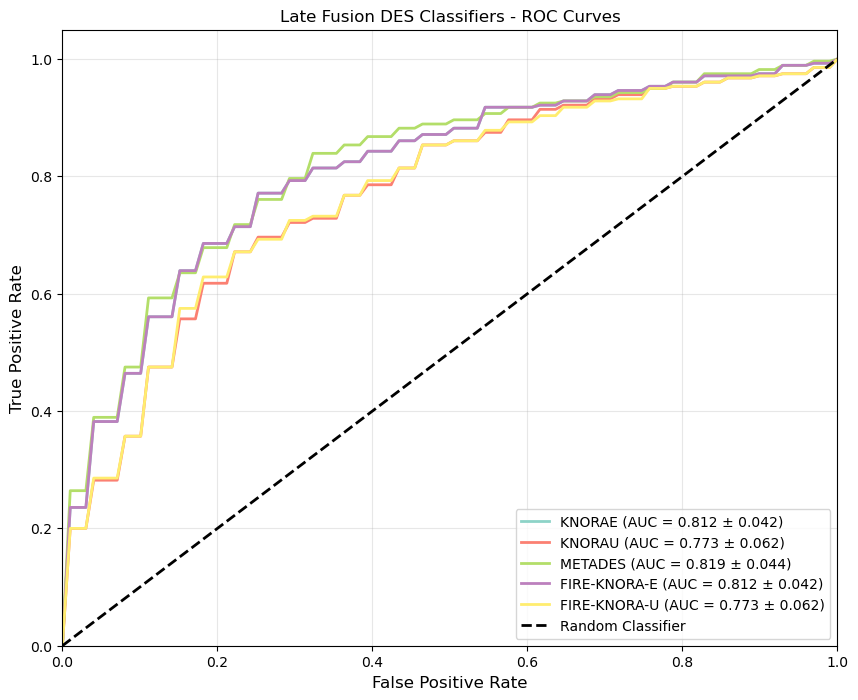


Late Fusion DES - Friedman Test Statistic: 21.628318584070797, p-value: 0.00023761459634995152
Late Fusion DES - Critical Difference: 1.928987299076902


<Figure size 1400x800 with 0 Axes>

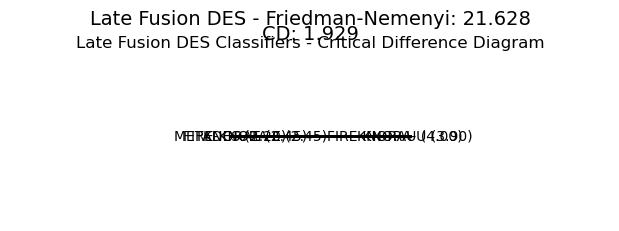

In [62]:
# Display Late Fusion DES Results
print('\nLate Fusion DES - Average Metrics over 10 Random States:')
for des_name, metrics in metric_sums_late_des.items():
    if len(accuracy_scores_late_des[des_name]) > 0:  # Check if we have results
        avg_accuracy = metrics['accuracy'] / len(accuracy_scores_late_des[des_name])
        avg_precision = metrics['precision'] / len(accuracy_scores_late_des[des_name])
        avg_recall = metrics['recall'] / len(accuracy_scores_late_des[des_name])
        avg_f1 = metrics['f1'] / len(accuracy_scores_late_des[des_name])
        std_accuracy = np.std(accuracy_scores_late_des[des_name])
        std_precision = np.std(precision_scores_late_des[des_name])
        std_recall = np.std(recall_scores_late_des[des_name])
        std_f1 = np.std(f1_scores_late_des[des_name])
        avg_auc = np.mean(roc_aucs_late_des[des_name])
        print(f'{des_name} - Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}, Precision: {avg_precision:.4f} ± {std_precision:.4f}, Recall: {avg_recall:.4f} ± {std_recall:.4f}, F1-Score: {avg_f1:.4f} ± {std_f1:.4f}, AUC: {avg_auc:.4f}')
    else:
        print(f'{des_name} - No results (failed to train)')

# Filter out empty results for visualization and statistical testing
valid_des_methods = {k: v for k, v in accuracy_scores_late_des.items() if len(v) > 0}

if len(valid_des_methods) > 1:  # Need at least 2 methods for comparison
    # Plot ROC Curves for Late Fusion DES (only valid methods)
    valid_roc_curves = {k: v for k, v in roc_curves_late_des.items() if k in valid_des_methods}
    if valid_roc_curves:
        plot_combined_roc_curve(valid_roc_curves, valid_des_methods.keys())
        plt.title('Late Fusion DES Classifiers - ROC Curves')
        plt.show()

    # Ensure all methods have the same number of results for statistical testing
    min_results = min(len(scores) for scores in valid_des_methods.values())
    
    # Truncate all results to the minimum length
    balanced_accuracy_scores = {}
    for method, scores in valid_des_methods.items():
        balanced_accuracy_scores[method] = scores[:min_results]
    
    # Friedman Test and CD Diagram for Late Fusion DES
    if len(balanced_accuracy_scores) >= 2 and min_results >= 2:
        try:
            df_late_des = pd.DataFrame(balanced_accuracy_scores)
            scores_late_des = [df_late_des[col].values for col in df_late_des.columns]
            stat_late_des, p_late_des = friedmanchisquare(*scores_late_des)
            print(f'\nLate Fusion DES - Friedman Test Statistic: {stat_late_des}, p-value: {p_late_des}')

            ranks_late_des = df_late_des.rank(axis=1, method='average', ascending=False)
            average_ranks_late_des = ranks_late_des.mean().values
            n_datasets_late_des = df_late_des.shape[0]
            cd_late_des = compute_CD(average_ranks_late_des, n_datasets_late_des, alpha='0.05')
            print(f'Late Fusion DES - Critical Difference: {cd_late_des}')

            classifiers_ranked_late_des = [f"{des} ({rank:.2f})" for des, rank in zip(df_late_des.columns, average_ranks_late_des)]
            plt.figure(figsize=(14, 8))
            graph_ranks(average_ranks_late_des, classifiers_ranked_late_des, cd=cd_late_des, width=6, textspace=1)
            plt.text(0.5, 1.19, f'Late Fusion DES - Friedman-Nemenyi: {stat_late_des:.3f}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
            plt.text(0.5, 1.10, f'CD: {cd_late_des:.3f}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
            plt.title('Late Fusion DES Classifiers - Critical Difference Diagram')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error in statistical testing: {e}")
            print("Skipping Friedman test and CD diagram for DES methods")
    else:
        print(f"Insufficient data for statistical testing. Need at least 2 methods with 2+ results each.")
        print(f"Available: {len(balanced_accuracy_scores)} methods, min results: {min_results}")
else:
    print("No valid DES results for comparison")

# Final Comparison: Early Fusion vs Late Fusion

Comprehensive comparison between early fusion (consolidated dataset) and late fusion (separate datasets with meta-classifier) approaches across all three classifier types.

In [58]:
# Comprehensive Comparison: Early Fusion vs Late Fusion
print("\\n" + "="*100)
print("COMPREHENSIVE COMPARISON: EARLY FUSION vs LATE FUSION")
print("="*100)

# Create comprehensive results dataframe
all_results = []

# Early Fusion Results
# Classical
for clf_name, metrics in metric_sums_classic.items():
    avg_accuracy = metrics['accuracy'] / 10
    avg_auc = np.mean(roc_aucs_classic[clf_name])
    all_results.append({
        'Method': f'Early_Classical_{clf_name}',
        'Fusion_Type': 'Early',
        'Classifier_Type': 'Classical',
        'Classifier': clf_name,
        'Accuracy': avg_accuracy,
        'AUC': avg_auc
    })

# Static
for clf_name, metrics in metric_sums_static.items():
    avg_accuracy = metrics['accuracy'] / 10
    avg_auc = np.mean(roc_aucs_static[clf_name])
    all_results.append({
        'Method': f'Early_Static_{clf_name}',
        'Fusion_Type': 'Early',
        'Classifier_Type': 'Static',
        'Classifier': clf_name,
        'Accuracy': avg_accuracy,
        'AUC': avg_auc
    })

# DES
for des_name, metrics in metric_sums_des.items():
    avg_accuracy = metrics['accuracy'] / 10
    avg_auc = np.mean(roc_aucs[des_name])
    all_results.append({
        'Method': f'Early_DES_{des_name}',
        'Fusion_Type': 'Early',
        'Classifier_Type': 'DES',
        'Classifier': des_name,
        'Accuracy': avg_accuracy,
        'AUC': avg_auc
    })

# Late Fusion Results
# Classical
for clf_name, metrics in metric_sums_late_classical.items():
    avg_accuracy = metrics['accuracy'] / 10
    avg_auc = np.mean(roc_aucs_late_classical[clf_name])
    all_results.append({
        'Method': f'Late_Classical_{clf_name}',
        'Fusion_Type': 'Late',
        'Classifier_Type': 'Classical',
        'Classifier': clf_name,
        'Accuracy': avg_accuracy,
        'AUC': avg_auc
    })

# Static
for clf_name, metrics in metric_sums_late_static.items():
    avg_accuracy = metrics['accuracy'] / 10
    avg_auc = np.mean(roc_aucs_late_static[clf_name])
    all_results.append({
        'Method': f'Late_Static_{clf_name}',
        'Fusion_Type': 'Late',
        'Classifier_Type': 'Static',
        'Classifier': clf_name,
        'Accuracy': avg_accuracy,
        'AUC': avg_auc
    })

# DES
for des_name, metrics in metric_sums_late_des.items():
    avg_accuracy = metrics['accuracy'] / 10
    avg_auc = np.mean(roc_aucs_late_des[des_name])
    all_results.append({
        'Method': f'Late_DES_{des_name}',
        'Fusion_Type': 'Late',
        'Classifier_Type': 'DES',
        'Classifier': des_name,
        'Accuracy': avg_accuracy,
        'AUC': avg_auc
    })

# Create DataFrame
results_df = pd.DataFrame(all_results)

# Sort by AUC
results_df_sorted = results_df.sort_values('AUC', ascending=False).reset_index(drop=True)
results_df_sorted['Rank'] = range(1, len(results_df_sorted) + 1)

print("\\nTOP 20 METHODS BY AUC:")
print("-" * 80)
top_20 = results_df_sorted.head(20)
for _, row in top_20.iterrows():
    print(f"{row['Rank']:2d}. {row['Method']:25s} | AUC: {row['AUC']:.4f} | Acc: {row['Accuracy']:.4f}")

# Comparison by fusion type
print("\\n" + "="*80)
print("COMPARISON BY FUSION TYPE")
print("="*80)

early_fusion_results = results_df[results_df['Fusion_Type'] == 'Early']
late_fusion_results = results_df[results_df['Fusion_Type'] == 'Late']

print(f"Early Fusion - Best AUC: {early_fusion_results['AUC'].max():.4f} | Average AUC: {early_fusion_results['AUC'].mean():.4f}")
print(f"Late Fusion - Best AUC: {late_fusion_results['AUC'].max():.4f} | Average AUC: {late_fusion_results['AUC'].mean():.4f}")

print(f"Early Fusion - Best Accuracy: {early_fusion_results['Accuracy'].max():.4f} | Average Accuracy: {early_fusion_results['Accuracy'].mean():.4f}")
print(f"Late Fusion - Best Accuracy: {late_fusion_results['Accuracy'].max():.4f} | Average Accuracy: {late_fusion_results['Accuracy'].mean():.4f}")

# Comparison by classifier type
print("\\n" + "="*80)
print("COMPARISON BY CLASSIFIER TYPE")
print("="*80)

for classifier_type in ['Classical', 'Static', 'DES']:
    print(f"\\n{classifier_type} Classifiers:")
    print("-" * 40)
    
    early_type = results_df[(results_df['Fusion_Type'] == 'Early') & (results_df['Classifier_Type'] == classifier_type)]
    late_type = results_df[(results_df['Fusion_Type'] == 'Late') & (results_df['Classifier_Type'] == classifier_type)]
    
    if not early_type.empty and not late_type.empty:
        print(f"Early Fusion - Best AUC: {early_type['AUC'].max():.4f} | Average AUC: {early_type['AUC'].mean():.4f}")
        print(f"Late Fusion - Best AUC: {late_type['AUC'].max():.4f} | Average AUC: {late_type['AUC'].mean():.4f}")
        print(f"Improvement: {((late_type['AUC'].max() - early_type['AUC'].max()) / early_type['AUC'].max() * 100):+.2f}%")

# Best performing method overall
best_method = results_df_sorted.iloc[0]
print(f"\\n" + "="*80)
print("BEST PERFORMING METHOD OVERALL")
print("="*80)
print(f"Method: {best_method['Method']}")
print(f"Fusion Type: {best_method['Fusion_Type']}")
print(f"Classifier Type: {best_method['Classifier_Type']}")
print(f"Classifier: {best_method['Classifier']}")
print(f"AUC: {best_method['AUC']:.4f}")
print(f"Accuracy: {best_method['Accuracy']:.4f}")

# Statistical significance testing between fusion types
print(f"\\n" + "="*80)
print("STATISTICAL SIGNIFICANCE TESTING")
print("="*80)

from scipy.stats import ttest_rel

# Compare AUC scores between Early and Late fusion for the same classifiers
classical_early_auc = [np.mean(roc_aucs_classic[clf]) for clf in classifiers_classical.keys()]
classical_late_auc = [np.mean(roc_aucs_late_classical[clf]) for clf in classifiers_classical.keys()]

static_early_auc = [np.mean(roc_aucs_static[clf]) for clf in classifiers_static_late.keys()]
static_late_auc = [np.mean(roc_aucs_late_static[clf]) for clf in classifiers_static_late.keys()]

des_early_auc = [np.mean(roc_aucs[des]) for des in metric_sums_late_des.keys()]
des_late_auc = [np.mean(roc_aucs_late_des[des]) for des in metric_sums_late_des.keys()]

# Paired t-tests
t_stat_classical, p_val_classical = ttest_rel(classical_early_auc, classical_late_auc)
t_stat_static, p_val_static = ttest_rel(static_early_auc, static_late_auc)
t_stat_des, p_val_des = ttest_rel(des_early_auc, des_late_auc)

print(f"Classical Classifiers - Early vs Late Fusion:")
print(f"  t-statistic: {t_stat_classical:.4f}, p-value: {p_val_classical:.6f}")
print(f"  Significant difference: {'Yes' if p_val_classical < 0.05 else 'No'}")

print(f"\\nStatic Classifiers - Early vs Late Fusion:")
print(f"  t-statistic: {t_stat_static:.4f}, p-value: {p_val_static:.6f}")
print(f"  Significant difference: {'Yes' if p_val_static < 0.05 else 'No'}")

print(f"\\nDES Classifiers - Early vs Late Fusion:")
print(f"  t-statistic: {t_stat_des:.4f}, p-value: {p_val_des:.6f}")
print(f"  Significant difference: {'Yes' if p_val_des < 0.05 else 'No'}")

print("\\n" + "="*100)
print("ANALYSIS COMPLETE")
print("="*100)

\n====================================================================================================
COMPREHENSIVE COMPARISON: EARLY FUSION vs LATE FUSION


NameError: name 'metric_sums_classic' is not defined